> 02-04 : Simple Models

## Introduction

In this project, we focus on predicting student performance during game-based learning in real-time using the dataset provided in the Kaggle competition titled ["Predict Student Performance from Game Play."](https://www.kaggle.com/competitions/predict-student-performance-from-game-play/) The dataset consists of time series data from an online educational game, containing various features such as elapsed time, event name, level, and more. Our primary goal is to develop a model that can accurately predict whether students will answer questions correctly at different checkpoints in the game.

In recent years, game-based learning has gained traction as an engaging and enjoyable educational approach. By applying deep learning techniques to analyze game-based learning data, we can help researchers and developers create more effective learning experiences for students. Furthermore, the results of our analysis can contribute to the advancement of knowledge-tracing methods in educational games.

The objectives of this project are as follows:

1.	Explore and understand the dataset: Analyze the provided data, preprocess it, and perform feature engineering to extract relevant information for our model.
2.	Develop and train models: Experiment with various model architectures suitable for time series data to find the best model for predicting student performance.
3.	Evaluate model performance: Assess the performance of the developed models on a test dataset using appropriate evaluation metrics.
4.	Optimize the chosen model: Fine-tune the best-performing model to improve accuracy and adhere to the competition compute constraints and efficiency prize requirements.
5.	Document findings: Present the results of our analysis, including the model architectures explored, their performance, and the rationale behind selecting the best model.

By achieving these goals, we aim to create a competitive submission for the Kaggle competition while contributing to improving game-based learning platforms and their ability to support individual students.

### Motivation for Choosing the Dataset

This dataset was chosen for several reasons that align with our objectives and interests in the field of educational technology and data science:

1.	Real-world impact: The dataset offers an opportunity to make a tangible difference in the educational landscape by enhancing game-based learning experiences for students. By developing an accurate predictive model, we can help improve educational games and support educators in tailoring these games to individual student needs.

2.	Advancing research in game-based learning: The dataset presents an opportunity to contribute to knowledge tracing in educational games. By exploring various deep learning techniques, we can advance our understanding of how data science and learning analytics can be applied to game-based learning platforms.

3.	Unique challenge: The time series nature of the dataset provides a unique challenge, requiring us to employ specialized models and techniques to analyze the data effectively. This allows us to broaden our skill set and gain experience working with time series data in the context of educational games.

4.	Efficiency prize: The competition's emphasis on creating small, lightweight, and efficient models adds complexity and encourages us to think critically about our design choices. This competition aspect motivates us to explore innovative solutions that balance model performance with computational constraints.

5.	Collaboration and learning: Participating in a Kaggle competition provides an opportunity to collaborate with a diverse community of data scientists, learn from their experiences, and share our findings. This engagement helps us refine our skills, stay updated on the latest techniques, and contribute to the broader data science community.

By working with this dataset, we hope to address these motivations while gaining valuable insights into the potential of deep learning techniques in enhancing game-based learning experiences for students.

### Evaluation Metric

The competition uses the F1 macro average score as the evaluation metric. This metric is calculated by taking the average of the F1 scores for each class. Although we are doing binary classification (is the answer correct), the split is between 0 and 1 as will be seen in the classification reports throughout the notebook.

The F1 score is a measure of a model's accuracy on a dataset and is defined as the harmonic mean of the model's precision and recall. Precision is the ratio of true positives to the sum of true positives and false positives, while recall is the ratio of true positives to the sum of true positives and false negatives. The F1 score is calculated as follows:

In [1]:
import sys
import logging
from typing import Iterable, List, Tuple

import numpy as np
import pandas as pd
import math

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
import keras as k
from keras import backend as K
from keras import callbacks

from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split


2023-04-21 09:51:46.427118: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set the GPU memory from growth
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-04-21 09:51:47.529201: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-21 09:51:47.530927: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-21 09:51:47.531083: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


### Configure Logging

In [3]:
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
        handlers=[
        logging.StreamHandler(sys.stdout)
    ])

logging.info("Started")

2023-04-21 09:51:47 INFO     Started


### Markdown Output

This is a set of convenience functions for displaying markdown output in the notebook.

In [4]:
from IPython.display import Markdown

# Initialize an empty list to store the lines of markdown
_markdown_lines = []

def mprint(text):
    global _markdown_lines
    _markdown_lines.append(text)

def mflush():
    global _markdown_lines
    markdown_string = "\n".join(_markdown_lines)
    display(Markdown(markdown_string))
    # Clear the lines after displaying the markdown
    _markdown_lines = []

## Data Collection

In [5]:
# the idea for the datatypes were taken from an existing kaggle 
# competition notebook. Sessions are loaded as integers as it
# speeds up queries.
dtypes = {
    "session_id": np.int64,
    "elapsed_time": np.int32,
    "event_name": "category",
    "name": "category",
    "level": np.uint8,
    "page": "category",
    "room_coor_x": np.float32,
    "room_coor_y": np.float32,
    "screen_coor_x": np.float32,
    "screen_coor_y": np.float32,
    "hover_duration": np.float32,
    "text": "category",
    "fqid": "category",
    "room_fqid": "category",
    "text_fqid": "category",
    "fullscreen": "category",
    "hq": "category",
    "music": "category",
    "level_group": "category",
}

In [6]:
# load the source training set
df_source = pd.read_csv('../data/train.csv.gz', compression='gzip', dtype=dtypes)

print(df_source.shape)
with pd.option_context('display.max_columns', None):
    display(df_source.head(3))

(13174211, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4


In [7]:
# load the source training labels
df_source_labels = pd.read_csv('../data/train_labels.csv')

print(df_source_labels.shape)
with pd.option_context('display.max_columns', None):
    display(df_source_labels.head(3))

(212022, 2)


,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090314121766812_q1,1


## Data Preparation & Cleaning

### Functions

In [8]:
def map_question_to_level_group(question_number):
    """
    Maps the question number to the level group.

    Parameters
    ----------
    question_number : int
        The question number.

    Returns
    -------
    str
        The level group.
    """
    if question_number in [1, 2, 3]:
        return '0-4'
    elif question_number in [4, 5, 6, 7, 8, 9, 10, 11, 12, 13]:
        return '5-12'
    elif question_number in [14, 15, 16, 17, 18]:
        return '13-22'
    else:
        return None

In [9]:
def find_problem_sessions(data : pd.DataFrame) -> List[str]:
    """
    Finds the sessions that are duplicated on session_id and index. And
    Find sessions with reversed indexes.

    This idea is taken from the following Kaggle notebook:
    https://www.kaggle.com/code/abaojiang/eda-on-game-progress/notebook?scriptVersionId=120133716
    
    Parameters
    ----------
    data : pd.DataFrame
        The data to search.

    Returns
    -------
    List[str]
        The list of session ids that have a problem.
    """

    # find sessions duplicated on session_id and index
    sessions_with_duplicates = df_source.loc[
        data.duplicated(subset=["session_id", "index"], keep=False)] \
        ["session_id"].unique().tolist()


    # find sessions with reversed indexes
    sessions_with_reversed_index = []
    for sess_id, gp in df_source.groupby("session_id", observed=True):
        if not gp["index"].is_monotonic_increasing:
            sessions_with_reversed_index.append(sess_id)

    # via experimentation these sessions have been found to have time 
    # differences < -2000
    negative_time_diff_sessions = [
        '21030417085341900', '21070111080982292', 
        '21090108302064196', '21090409222921812']

    # combine the two lists into a single set
    return set(sessions_with_duplicates + sessions_with_reversed_index + negative_time_diff_sessions)


In [10]:
def prepare_label_dataset(data : pd.DataFrame) -> pd.DataFrame:
    """
    Prepares the label dataset and add columns for the level group 
    and the question number.

    Parameters
    ----------
    data : pd.DataFrame
        The label dataset.

    Returns
    -------
    pd.DataFrame
        The prepared label dataset.
    """
    # add the columns to determine the level group
    df_labels = data \
        .rename(columns={'session_id': 'id'}) \
        .assign(session_id=lambda df: df['id'].str.split('_').str[0].astype(int)) \
        .assign(question_id=lambda df: df['id'].str.split('_').str[1]) \
        .assign(question_num=lambda df: df['question_id'].str[1:].astype(int)) \
        [['session_id', 'question_num', 'correct']]
    
    # add the level group column
    df_labels['level_group'] = df_labels['question_num'].apply(map_question_to_level_group) 
        
    return df_labels

In [11]:
def prepare_main_dataset(data : pd.DataFrame,
                         elapsed_time_min_clip:int=0,
                         elapsed_time_max_clip:int=3691298) -> pd.DataFrame:
    """
    Prepares the main dataset by removing duplicates and removing 
    columns that are not needed.

    Parameters
    ----------
    data : pd.DataFrame
        The main dataset.

    Returns
    -------
    pd.DataFrame
        The prepared main dataset.
    """
    empty_columns = ['fullscreen', 'hq', 'music', 'page', 'hover_duration']

    df_main = data \
        .drop_duplicates() \
        .reset_index(drop=True) \
        .drop(empty_columns, axis=1) \
        .drop('text', axis=1)
    
    # clip the elapsed time to re```python
    return df_main

In [12]:
def get_clipping_values(data:pd.DataFrame, column:str, boxplot:bool=True) -> Tuple[float, float]:
    """
    To remove outliers, gets the clipping values for the specified column.

    Parameters
    ----------
    data : pd.DataFrame
        The data to search.
    column : str
        The column to search.
    boxplot : bool, optional
        If True, box plots are show for comparison, by default True.

    Returns
    -------
    Tuple[float, float]
        The clipping values.
    """
    # get the minimum and maximum values
    min_value = data[column].min()
    max_value = data[column].max()

    # get the inter quartile range
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)    
    iq_range = q3 - q1

    # get the clipping values
    min_clip = np.max([min_value, (q1 - (iq_range * 1.5))])
    max_clip = q3 + (iq_range * 1.5)

    # show the box plot
    if boxplot:
        # get the cliped values
        data_clipped = data[column].values.clip(min_clip, max_clip)

        # create the box plot next to each other
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        data[column].plot.box(ax=ax1)
        pd.Series(data_clipped).plot.box(ax=ax2)

        # set the title
        plt.suptitle(f'Box plot for {column}')
        ax1.set_title('Original')
        ax2.set_title('Clipped')

        # show the plot
        plt.show()

    return min_clip, max_clip

### Process the Data

We do not want outliers to affect our model, so we examine the range of values and pick clipping values based on the of standard deviations away from the mean that we will consider an outlier. We then remove the outliers.

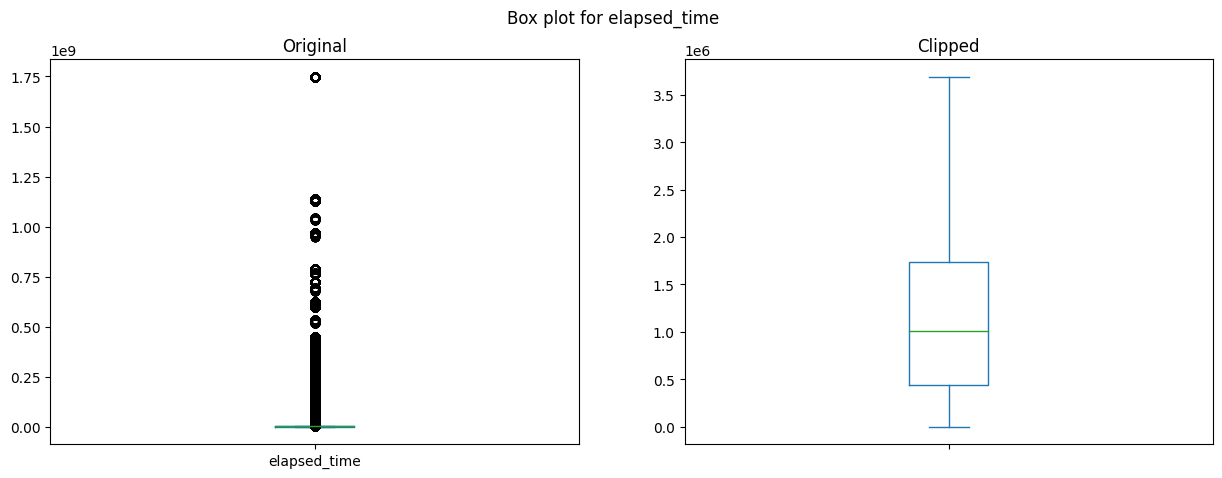

(0.0, 3690980.0)

In [13]:
# show the outliers in the elapsed_time column
get_clipping_values(df_source, 'elapsed_time', boxplot=True)

In [14]:
# prepare the main dataset
df_source = prepare_main_dataset(df_source, elapsed_time_min_clip=0, elapsed_time_max_clip=3691298)

# remove sessions with problems
problem_sessions = find_problem_sessions(df_source)
df_source = df_source[~df_source['session_id'].isin(problem_sessions)]

with pd.option_context('display.max_columns', None):
    print(df_source.shape)
    display(df_source.head(3))  

(13019794, 14)


,session_id,index,elapsed_time,event_name,name,level,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,fqid,room_fqid,text_fqid,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,-413.991394,-159.314682,380.0,494.0,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0-4
1,20090312431273200,1,1323,person_click,basic,0,-413.991394,-159.314682,380.0,494.0,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
2,20090312431273200,2,831,person_click,basic,0,-413.991394,-159.314682,380.0,494.0,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4


In [15]:
# prepare the label dataset
df_source_labels = prepare_label_dataset(df_source_labels)

# remove sessions with problems
df_source_labels = df_source_labels[~df_source_labels['session_id'].isin(problem_sessions)]

with pd.option_context('display.max_columns', None):
    display(df_source_labels.sample(n=3, random_state=51))

,session_id,question_num,correct,level_group
172317,21070319253640464,15,0,13-22
194865,21040512553883790,17,1,13-22
197728,22000108514966796,17,1,13-22


## Body of Work

The body of work that went into this assignment is much larger than can practically be included in a single Jupyter notebook, and much of the accompanying work leading to this submission had to be omitted. It is kindly requested that the work located at the following URL be considered part of this coursework: https://github.com/JohnnyFoulds/dsm150-2022-oct/tree/master/cw02

The notebooks are in the `phase_01` and `phase_02` directories. After the submission date, additional phases may be created that were unavailable at submission time.

### GAN Detour
During the coursework, it became apparent that there is a limit to the predictive power of the dataset, and a Generative project was briefly considered.

https://github.com/JohnnyFoulds/dsm150-2022-oct/tree/master/cw02/marvel_superhero_gan

#### Superhero Dataset

The initial idea was to try and generate superheroes, and for an initial test, Marvel superhero thumbnails were downloaded using the Marvel API.  

If the initial results proved promising, a more extensive search would be needed for a non-proprietary dataset of superhero images to not infringe on copyright.

https://github.com/JohnnyFoulds/dsm150-2022-oct/blob/master/cw02/marvel_superhero_gan/04_download_marvel.ipynb

#### Superhero Results

The results were interesting, especially when viewing the training progression, but unfortunately, the final result did not meet the initial goal of creating identifiable superheroes. The problem here is that the dataset is not large enough, but more importantly, heavy curation of the images would be needed. Looking at the training progression and the final result, we can see that the input is too varied, where some thumbnails are an excellent isolated image of the superhero, and others have much noise in the background, such as scenery or multiple other characters present in the image.

https://github.com/JohnnyFoulds/dsm150-2022-oct/blob/master/cw02/marvel_superhero_gan/03_64x64_images.ipynb

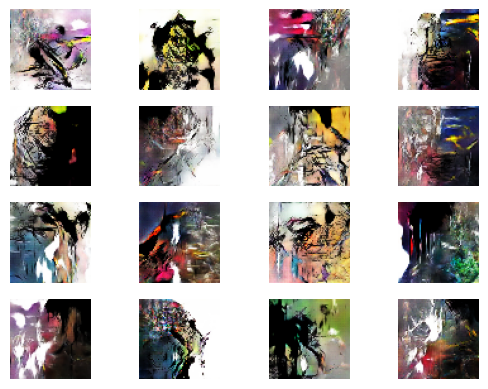

#### Anime Faces
A publicly available dataset of Anime faces was used next to overcome the limitations of the previous dataset. The output was quite promising and can be improved with further work and using more modern generator architectures.

https://github.com/JohnnyFoulds/dsm150-2022-oct/blob/master/cw02/marvel_superhero_gan/06_anime_face.ipynb

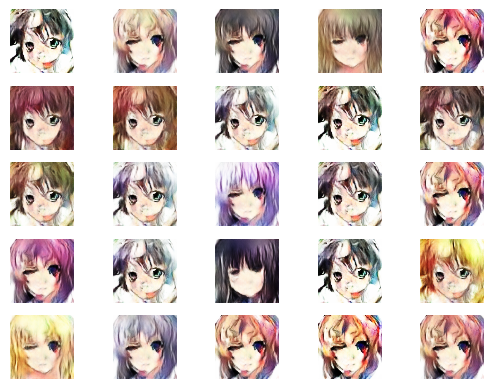

### Exploratory Data Analysis

The EDA is spread across my notebooks and was done in a goal oriented way to investigate the idea explored in the notebook.

In [01_data_preperation.ipynb](https://github.com/JohnnyFoulds/dsm150-2022-oct/blob/master/cw02/phase_01/01_data_preperation.ipynb) the data was summarized by group and the ration of correct answers were calculated

```
             min  max      mean  correct_perc
level_group                                  
0-4            0    3  2.634944      0.878315
13-22          0    5  3.566771      0.713354
5-12           0   10  6.469310      0.646931
```

As a baseline we simply then marked all questions as correct and got the following result:

```
              precision    recall  f1-score   support

           0       1.00      0.00      0.00     62770
           1       0.70      1.00      0.83    149252

    accuracy                           0.70    212022
   macro avg       0.85      0.50      0.41    212022
weighted avg       0.79      0.70      0.58    21202
```

Next the same methodology was used but at a question level. These ratios were then used to perform predictions.

```python
def predict_cheater(x : list, rations: list):
    y_pred = []
    np.random.seed(1230)

    for question_num in tqdm(x):
        y_pred.append(np.random.binomial(1, rations[question_num - 1]))

    return y_pred
        
y_pred = predict_cheater(
    x=df_augmented_labels.question_num.values,
    rations=df_question_perf.correct_perc.values)

# show the classification report
print(classification_report(df_augmented_labels['correct'], y_pred))
```

```
              precision    recall  f1-score   support

           0       0.40      0.40      0.40     62770
           1       0.75      0.75      0.75    149252

    accuracy                           0.64    212022
   macro avg       0.57      0.57      0.57    212022
weighted avg       0.64      0.64      0.64    212022
```

Another example is seen in the [02-02_time_series.ipynb](https://github.com/JohnnyFoulds/dsm150-2022-oct/blob/master/cw02/phase_02/02-02_time_series.ipynb) notebook where the columns and the range of items contained in them are explored to select the best columns to use for the time series analysis approach.

The session clicks, which later evolved into the screen heatmap feature used in this report, are explored in [19_click_eda.ipynb]( https://github.com/JohnnyFoulds/dsm150-2022-oct/blob/master/cw02/phase_01/19_click_eda.ipynb). This investigation looked quite promising, but it is unclear how valuable this data might be. The game from which the data originates is very linear, and all the correct actions must be performed to progress to the next level. However, the hypothesis is that high-performing players might behave differently than the low scorers.


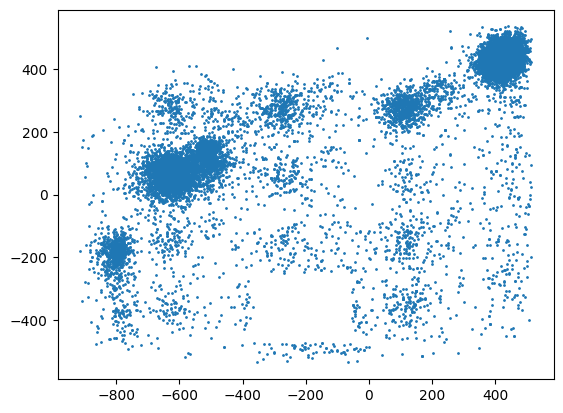

### Baseline Model

An extension of the baseline discussed in the EDA section was to simply always classify a particular question number the same regardless of what is contained in the feature data. The first attempt at this was to build a simple Decision Tree model to produce the answer key as shown in [21_feature_engineering.ipynb](https://github.com/JohnnyFoulds/dsm150-2022-oct/blob/master/cw02/phase_01/21_feature_engineering.ipynb).

```
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1]
```

This approach worked remarkably well for such a naïve approach, as seen in the classification result.

```
              precision    recall  f1-score   support

           0       0.58      0.33      0.42     12663
           1       0.76      0.90      0.82     29745

    accuracy                           0.73     42408
   macro avg       0.67      0.61      0.62     42408
weighted avg       0.71      0.73      0.70     42408
```

Next, an answer key that produced the best F1 score possible was found using brute force in [https://github.com/JohnnyFoulds/dsm150-2022-oct/blob/master/cw02/phase_02/02-03_brute.ipynb](02-03_brute.ipynb).

[1 1 1 1 0 1 1 0 1 0 1 1 0 1 0 1 1 1]

The new answer key markedly improved the F1 macro average to  `0.65` with a confirmed score of `0.648` in the [silly_monkey](https://www.kaggle.com/code/shambi/silly-monkey) notebook submitted to the Kaggle competition.

```python
correct_array = [1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1]

for (df, test) in iter_test:
    df = df \
        .assign(question=lambda df: df['session_id'].str.extract(r'_q(\d+)').astype(int)) \
        .assign(correct=lambda df: df['question'].apply(lambda q: correct_array[q - 1])) \
        .drop(columns=['question'])

    env.predict(df)
```

Comparing our result with the top score currently on the leaderboard, `0.708`, it is already a potential red flag indicating that the session log data might have limited predictive power. Instead, it appears that the questions might have a set pattern that determines if they are answered correctly based on factors like difficulty, screen layout and perhaps slight ambiguity in the possible answers.


### Time Series

Browsing through the source code repository shows the bulk of the initial work centred around modelling the log data as a time series. This is a highly memory-intensive task, and experiments were done with [generators]( https://github.com/JohnnyFoulds/dsm150-2022-oct/blob/master/cw02/phase_01/10_memory.ipynb) to try and overcome the limitations of the hardware we had access to. However, using the generators generally resulted in poor training performance, and an attempt was made to keep data in memory as much as possible.

Different RNNs were tried, such as [GRU and LSTM]( https://github.com/JohnnyFoulds/dsm150-2022-oct/blob/master/cw02/phase_01/06_basic_modeling.ipynb), and perhaps one of the more organized notebooks that can be examined is [02-02_time_series.ipynb](https://github.com/JohnnyFoulds/dsm150-2022-oct/blob/master/cw02/phase_02/02-02_time_series.ipynb).

Due to the size of the data, and the fact that this approach does not seem to improve performance over simpler techniques, we have decided not to include it in this notebook for reasons of practicality.


## Feature Engineering

### Functions

In [16]:
def create_initial_features(X:pd.DataFrame,
                            y:pd.DataFrame) -> pd.DataFrame:
    """
    Creates the initial dataset to which additional features will be added.

    Parameters
    ----------
    X : pd.DataFrame
        The main dataset.
    y : pd.DataFrame
        The label dataset.

    Returns
    -------
    pd.DataFrame
        The initial feature dataset.
    """
    df_features =  y \
        .groupby(['session_id', 'level_group']) \
        .agg({'correct': ['count']}) \
        .reset_index() \
        .droplevel(1, axis=1) \
        .drop(columns=['correct']) \
        .sort_values(['session_id', 'level_group']) \
        
    # set the session_id to be an integer
    df_features['session_id'] = df_features['session_id'].astype(int)
        
    return df_features        

In [17]:
def add_numeric_column_features(features:pd.DataFrame,
                                X:pd.DataFrame,
                                column:str,
                                min_values:dict=None,
                                max_values:dict=None) -> pd.DataFrame:
    """
    Add the maximum elapsed time feature to the features dataset.

    Parameters
    ----------
    features : pd.DataFrame
        The features dataset.
    X : pd.DataFrame
        The main dataset.
    column : str
        The name of the numeric column to add to the features for.

    Returns
    -------
    None
    """
    # Define a function to calculate mode
    def mode(series):
        return series.mode().iat[0]

    # calculate the maximum, minimum and mean for the column
    df_result = X \
        .groupby(['session_id', 'level_group']) \
        .agg({column: ['sum', 'max', 'min', 'mean', mode]}) \
        .reset_index()
    
    # flatten the multi-index columns
    df_result.columns = ['_'.join(col).rstrip('_') for col in df_result.columns.values]

    # normalize the values
    if min_values is None or max_values is None:
        logging.warning('Not normalizing the values, min_value and max_values are not set.')
    else:
        metric_list = ['sum', 'max', 'min', 'mean', 'mode']
        for metric in metric_list:
            current_column = f'{column}_{metric}'
            df_result[current_column] = (df_result[current_column] - min_values[metric]) / (max_values[metric] - min_values[metric])       

    # join the features to the result   
    df_result = features.set_index(['session_id', 'level_group']) \
        .join(df_result.set_index(['session_id', 'level_group']), how='left') \
        .reset_index()
    
    return df_result

In [18]:
def plot_numeric_features(df_features:pd.DataFrame,
                          colum:str) -> None:
    """
    Plot the numeric features for a column.
    """
    metric_list = ['sum', 'max', 'min', 'mean', 'mode']
    column_list = [f'{colum}_{metric}' for metric in metric_list]

    # plot the features
    df_features[column_list].plot(kind='box', subplots=True, layout=(2, 3), figsize=(15, 10))
    plt.show()

In [19]:
def add_count_total_features(features:pd.DataFrame,
                             X:pd.DataFrame,
                             columns:dict) -> pd.DataFrame:
    """
    Add the total count for the categorical columns to the features dataset.

    Parameters
    ----------
    features : pd.DataFrame
        The features dataset.
    X : pd.DataFrame
        The main dataset.
    columns : dict
        The columns to add to the features dataset as a dictionary 
        of column name and min & max value.

    Returns
    -------
    pd.DataFrame
        The features dataset with the total count features added.
    """
    df_count_total = X \
        .groupby(['session_id', 'level_group']) \
        .agg({col: 'count' for col in columns.keys()}) \
        .reset_index()
    
    # normalize the counts
    for col, min_max in columns.items():
        # clip the values
        df_count_total[col] = df_count_total[col].clip(min_max['total']['min'], min_max['total']['max'])

        # normalize the values
        df_count_total[col] = (df_count_total[col] - min_max['total']['min']) / (min_max['total']['max'] - min_max['total']['min'])

    # get the columns as a feature vector
    count_total_feature = df_count_total[columns.keys()].to_numpy()
    df_count_total['count_total_feature'] = pd.Series(count_total_feature.tolist())

    # drop the original columns
    df_count_total.drop(columns=columns.keys(), inplace=True)

    # add the feature to the features dataset
    df_result = features.set_index(['session_id', 'level_group']) \
        .join(df_count_total.set_index(['session_id', 'level_group']), how='left') \
        .reset_index()
    
    return df_result

In [20]:
def add_count_unique_features(features:pd.DataFrame,
                              X:pd.DataFrame,
                              columns:dict) -> pd.DataFrame:
    """
    Add the unique count for the categorical columns to the features dataset.

    Parameters
    ----------
    features : pd.DataFrame
        The features dataset.
    X : pd.DataFrame
        The main dataset.
    columns : dict
        The columns to add to the features dataset as a dictionary 
        of column name and min & max value.

    Returns
    -------
    pd.DataFrame
        The features dataset with the total count features added.
    """
    df_count_total = X \
        .groupby(['session_id', 'level_group']) \
        .agg({col: 'nunique' for col in columns.keys()}) \
        .reset_index()
    
    # normalize the counts
    for col, min_max in columns.items():
        # clip the values
        df_count_total[col] = df_count_total[col].clip(min_max['unique']['min'], min_max['unique']['max'])

        # normalize the values
        df_count_total[col] = (df_count_total[col] - min_max['unique']['min']) / (min_max['unique']['max'] - min_max['unique']['min'])

    # get the columns as a feature vector
    count_total_feature = df_count_total[columns.keys()].to_numpy()
    df_count_total['count_unique_feature'] = pd.Series(count_total_feature.tolist())

    # drop the original columns
    df_count_total.drop(columns=columns.keys(), inplace=True)

    # add the feature to the features dataset
    df_result = features.set_index(['session_id', 'level_group']) \
        .join(df_count_total.set_index(['session_id', 'level_group']), how='left') \
        .reset_index()
    
    return df_result

### Create Features

#### Initial Features

In [21]:
# create the initial features
df_features = create_initial_features(df_source, df_source_labels)

with pd.option_context('display.max_columns', None):
    display(df_features.head(6))

,session_id,level_group
0,20090312431273200,0-4
1,20090312431273200,13-22
2,20090312431273200,5-12
3,20090312433251036,0-4
4,20090312433251036,13-22
5,20090312433251036,5-12


#### Elapsed Time

In [22]:
# get the ranges to use for normalizing the values
df_unclipped = add_numeric_column_features(df_features, df_source, 'elapsed_time')
df_unclipped.describe()

2023-04-21 09:54:51 WARNING  Not normalizing the values, min_value and max_values are not set.


,session_id,elapsed_time_sum,elapsed_time_max,elapsed_time_min,elapsed_time_mean,elapsed_time_mode
count,3.494400e+04,3.494400e+04,3.494400e+04,3.494400e+04,3.494400e+04,3.494400e+04
mean,2.114901e+16,1.443802e+09,3.995209e+06,1.528633e+06,2.649569e+06,1.620532e+06
std,5.582462e+14,1.224066e+10,2.989930e+07,1.396355e+07,1.912270e+07,1.477429e+07
min,2.009031e+16,6.139500e+04,9.900000e+02,0.000000e+00,5.264470e+02,0.000000e+00
25%,2.101032e+16,2.838734e+07,3.607190e+05,0.000000e+00,1.644224e+05,0.000000e+00
50%,2.104031e+16,2.048533e+08,8.749455e+05,3.025925e+05,5.887672e+05,3.098890e+05
75%,2.111001e+16,6.690107e+08,1.773885e+06,9.188058e+05,1.346951e+06,9.423445e+05
max,2.210022e+16,1.018871e+12,1.749293e+09,9.640593e+08,9.691510e+08,9.640593e+08


In [23]:
# add the feature to the features dataset
df_features = add_numeric_column_features(
    features=df_features,
    X=df_source,
    column='elapsed_time',
    min_values={
        'sum': 61395.0,
        'max':  990.0,
        'min':  0.0,
        'mean': 526.447,
        'mode': 0.0},
    max_values={
        'sum':  9990648000,
        'max':  3691298.0,
        'min':  3691298.0,
        'mean': 3691298.0,
        'mode': 3691298.0})

with pd.option_context('display.max_columns', None):
    display(df_features.head(6))

,session_id,level_group,elapsed_time_sum,elapsed_time_max,elapsed_time_min,elapsed_time_mean,elapsed_time_mode
0,20090312431273200,0-4,0.001411,0.052535,0.000000,0.023103,0.000000
1,20090312431273200,13-22,0.043740,0.344602,0.226677,0.281804,0.301320
2,20090312431273200,5-12,0.010577,0.135014,0.060002,0.096641,0.060002
3,20090312433251036,0-4,0.001352,0.063074,0.000000,0.026311,0.000000
4,20090312433251036,13-22,0.324400,1.033611,0.318718,0.676912,0.318718
5,20090312433251036,5-12,0.021933,0.221287,0.072301,0.150206,0.072301


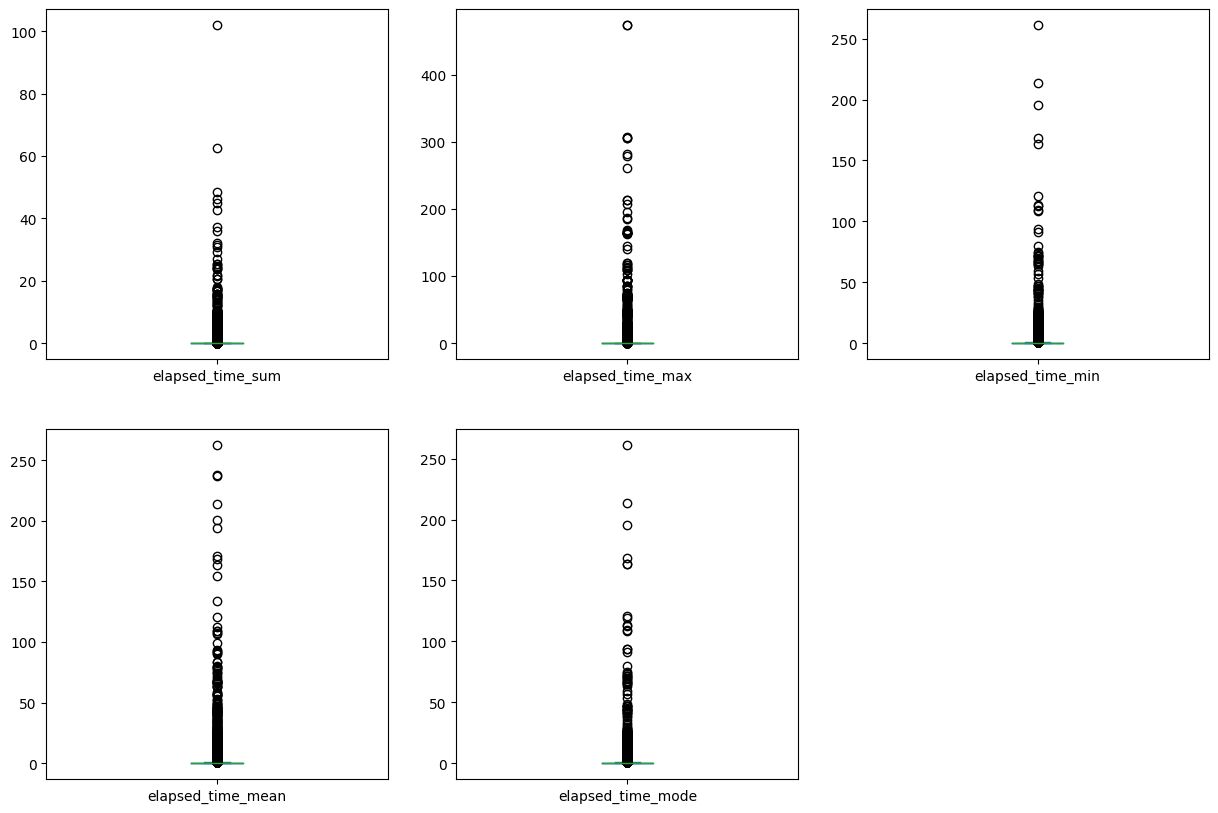

In [24]:
plot_numeric_features(df_features, 'elapsed_time')

#### Numeric Columns

In [ ]:
NUMERIC_COLUMNS = [
    'level',
    'page',
    'room_coor_x',
    'room_coor_y', 
    'screen_coor_x',
    'screen_coor_y',
    'hover_duration'
]

In [ ]:
# get the ranges to use for normalizing the values
df_unclipped = add_numeric_column_features(df_features, df_source, 'elapsed_time')
df_unclipped.describe()

#### Count Columns

Called count columns below because these columns are summarized by counting.

In [35]:
COUNT_COLUMNS = {
    'event_name': { 
        'total': {'min': 91.0, 'max': 924.5 },
        'unique': {'min': 7.0, 'max': 11.0 }
    },
    'name': { 
        'total': {'min': 91.0, 'max': 924.5 },
        'unique': {'min': 3.0, 'max': 6.0 }
    },
    'fqid': { 
        'total': {'min': 64.0, 'max': 683.0 },
        'unique': {'min': 18.0, 'max': 77.0 }
    },
    'room_fqid': { 
        'total': {'min': 91.0, 'max': 924.5 },
        'unique': {'min': 6.0, 'max': 17.0 }
    },
    'text_fqid': { 
        'total': {'min': 45.0, 'max': 359.5 },
        'unique': {'min': 8.0, 'max': 48.0 }
    },
    'level' : {
        'total': {'min': 91.0, 'max': 924.5 },
        'unique': {'min': 5, 'max': 10 }
    }
}

##### Total Count

In [26]:
# add the total count features to the features dataset
df_features = add_count_total_features(
    features=df_features,
    X=df_source,
    columns=COUNT_COLUMNS)

with pd.option_context('display.max_columns', None):
    display(df_features.head(6))

,session_id,level_group,elapsed_time_sum,elapsed_time_max,elapsed_time_min,elapsed_time_mean,elapsed_time_mode,count_total_feature
0,20090312431273200,0-4,0.001411,0.052535,0.000000,0.023103,0.000000,"[0.08878224355128975, 0.08878224355128975, 0.0..."
1,20090312431273200,13-22,0.043740,0.344602,0.226677,0.281804,0.301320,"[0.39472105578884226, 0.39472105578884226, 0.4..."
2,20090312431273200,5-12,0.010577,0.135014,0.060002,0.096641,0.060002,"[0.24595080983803239, 0.24595080983803239, 0.2..."
3,20090312433251036,0-4,0.001352,0.063074,0.000000,0.026311,0.000000,"[0.057588482303539294, 0.057588482303539294, 0..."
4,20090312433251036,13-22,0.324400,1.033611,0.318718,0.676912,0.318718,"[1.0, 1.0, 1.0, 1.0, 0.5850556438791733]"
5,20090312433251036,5-12,0.021933,0.221287,0.072301,0.150206,0.072301,"[0.36472705458908217, 0.36472705458908217, 0.4..."


Examine the data spread to determine clipping values to remove outliers. The clipping values will be put back into the `COUNT_COLUMNS` dictionary.

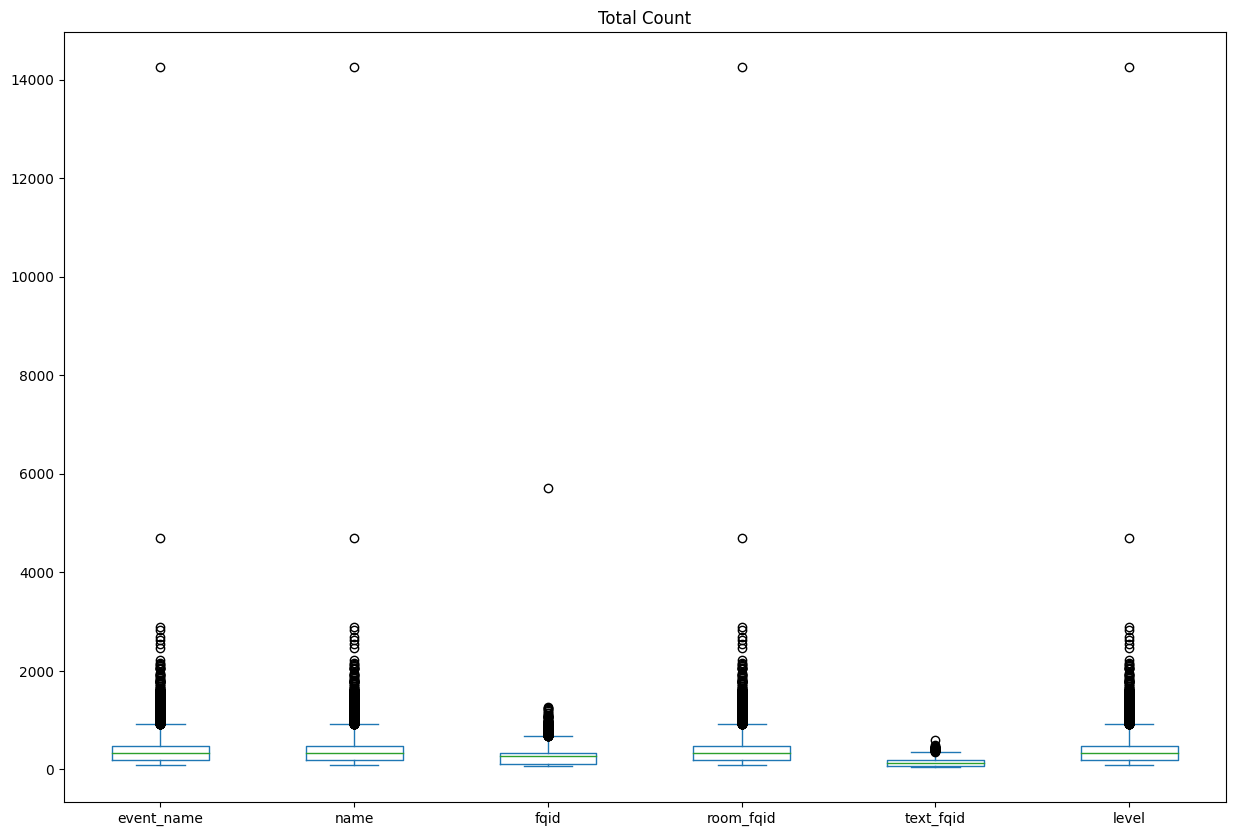

In [30]:
df_counts = df_source \
    .groupby(['session_id', 'level_group']) \
    .agg({col: 'count' for col in COUNT_COLUMNS.keys()}) \
    .reset_index() \
    .drop(columns=['session_id', 'level_group'])

df_counts.plot(kind='box', title='Total Count', figsize=(15, 10))
plt.show()

There are outliers present that will need to be removed to normalize the data.

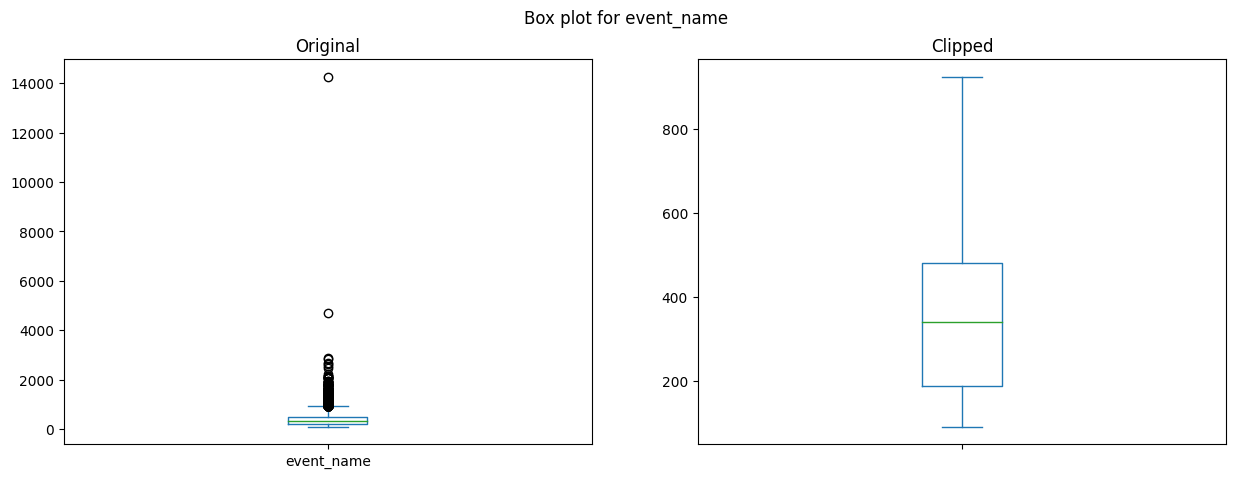

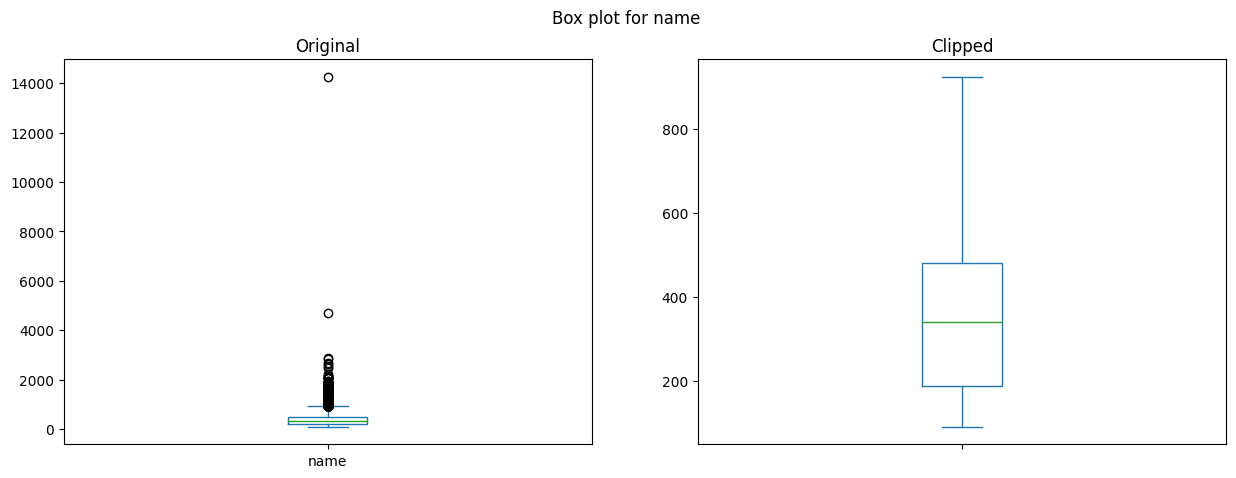

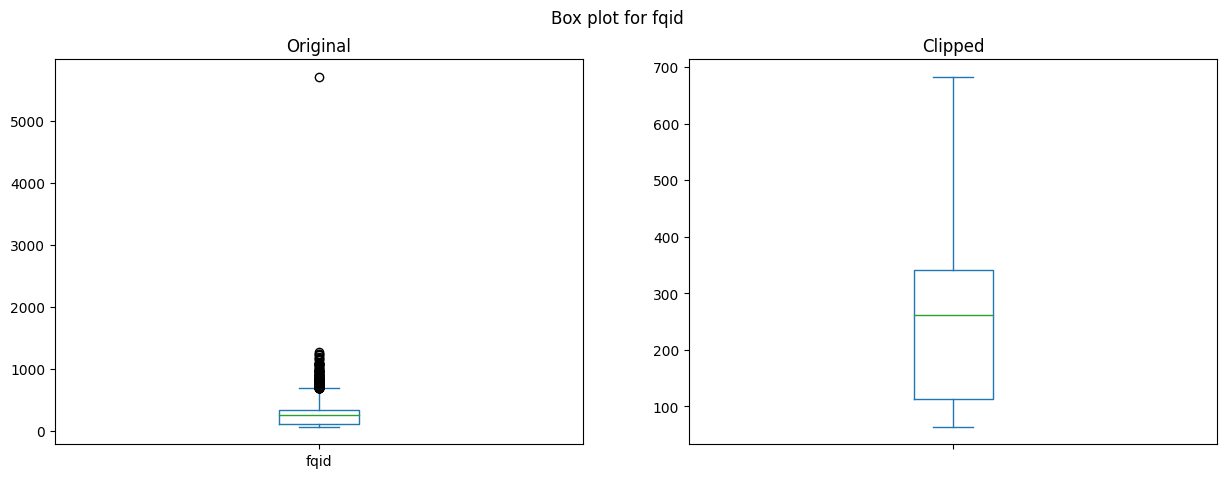

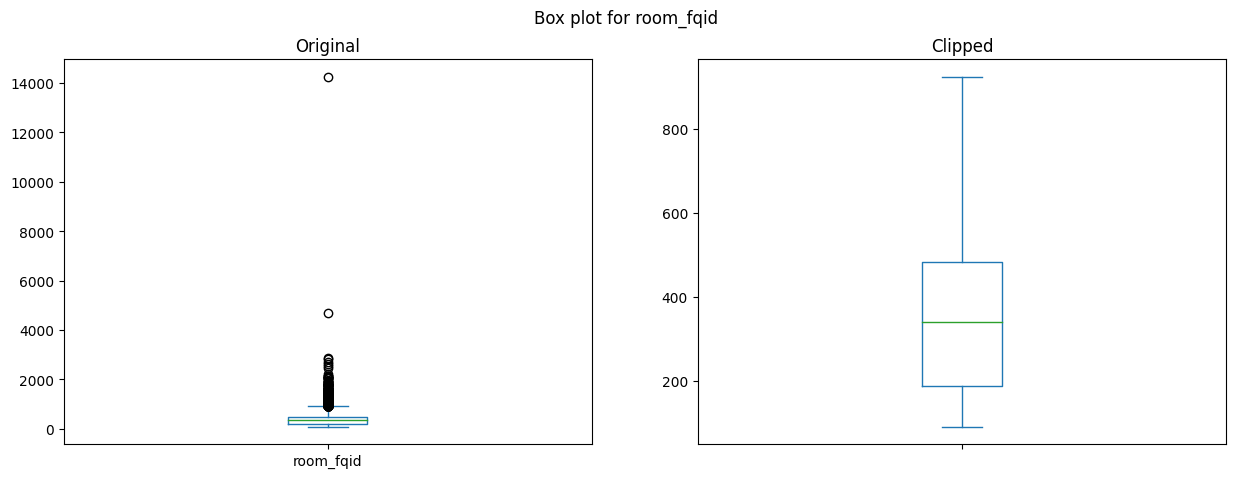

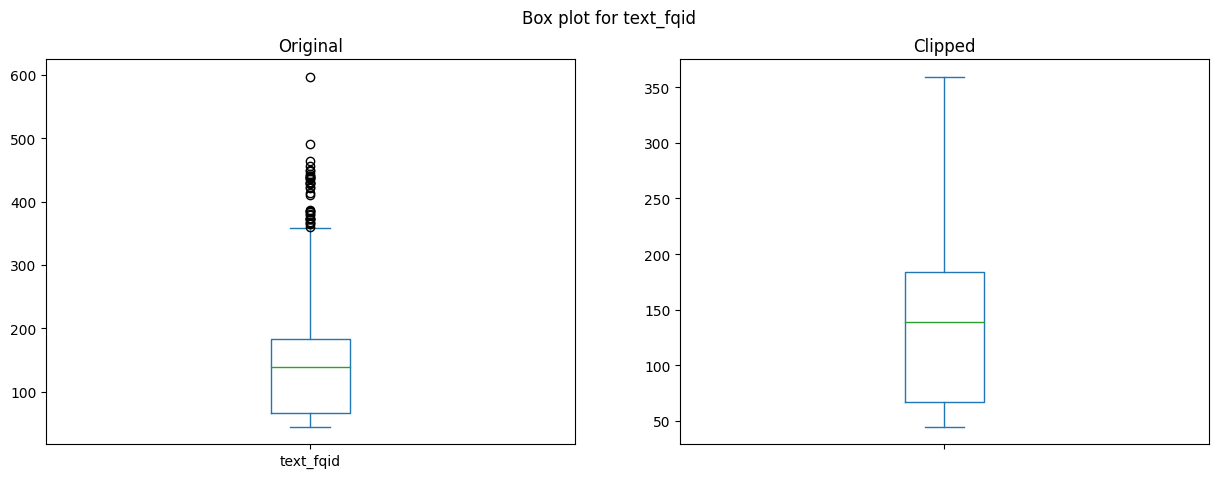

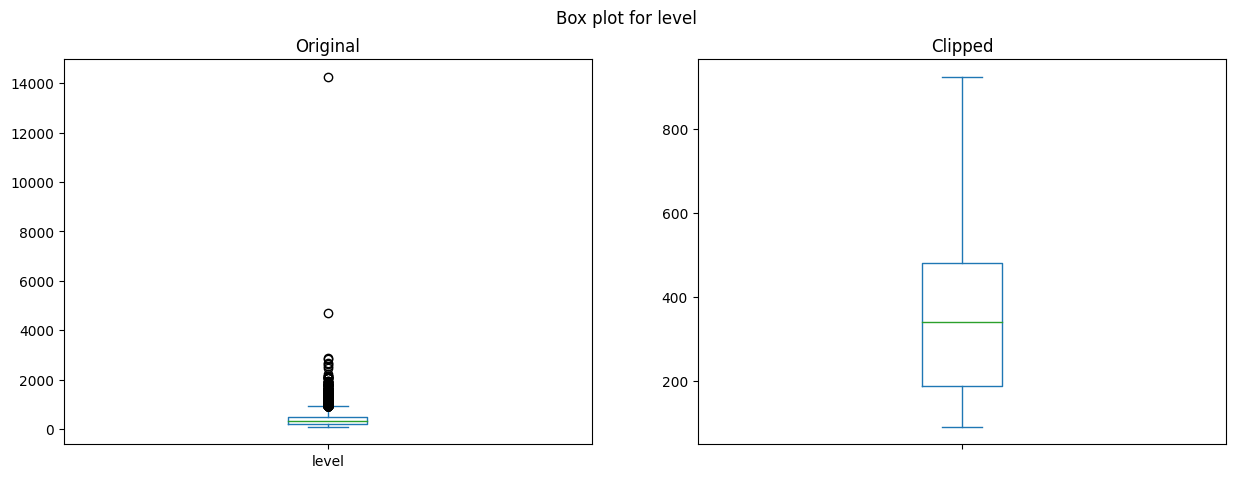

,column,min,max
0,event_name,91.0,924.5
1,name,91.0,924.5
2,fqid,64.0,683.0
3,room_fqid,91.0,924.5
4,text_fqid,45.0,359.5
5,level,91.0,924.5


In [31]:
results = []
for column in COUNT_COLUMNS.keys():
    clipping_values = get_clipping_values(df_counts, column, boxplot=True)
    results.append({
        'column': column,
        'min': clipping_values[0],
        'max': clipping_values[1]})
    
# display the results
display(pd.DataFrame(results))

##### Unique Count

In [32]:
# add the unique count features to the features dataset
df_features = add_count_unique_features(
    features=df_features,
    X=df_source,
    columns=COUNT_COLUMNS)

with pd.option_context('display.max_columns', None):
    display(df_features.head(6))

KeyError: 'unique'

Plot the unique counts to determine if clipping is necessary.

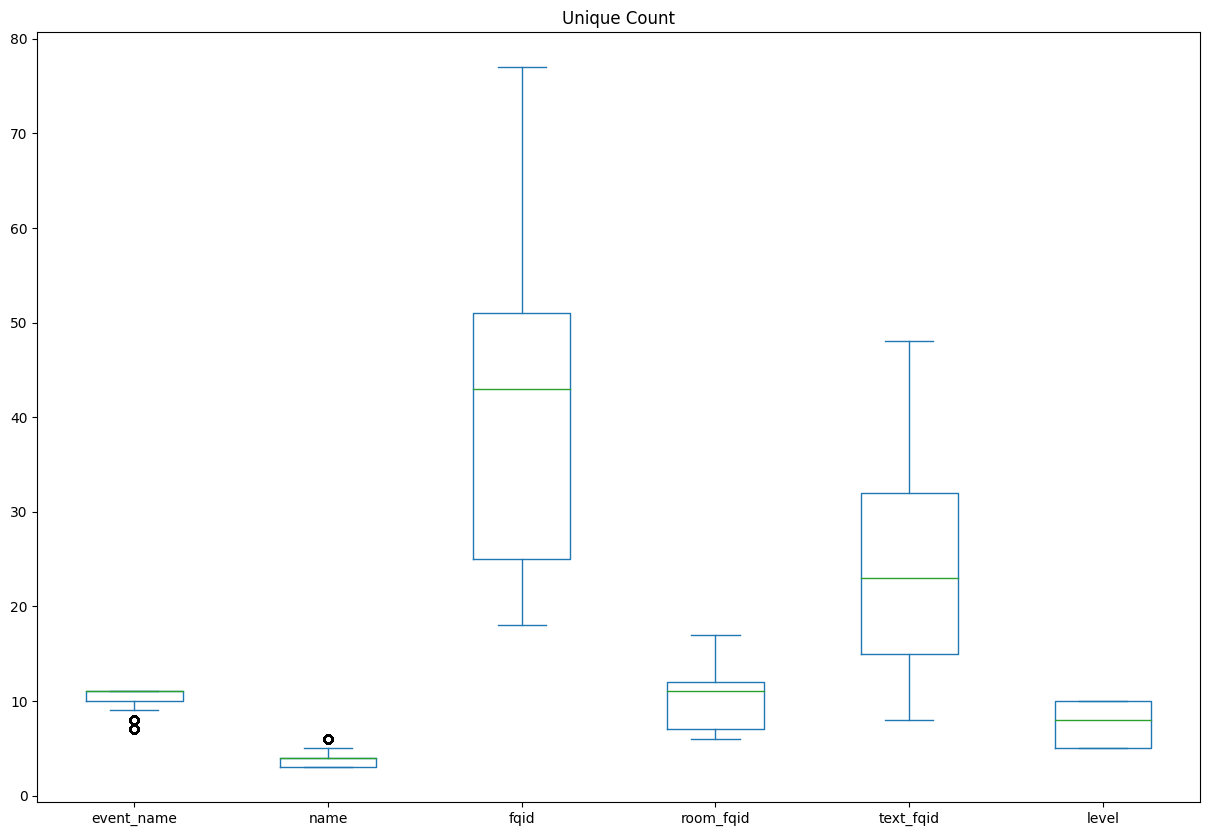

In [33]:
df_counts = df_source \
    .groupby(['session_id', 'level_group']) \
    .agg({col: 'nunique' for col in COUNT_COLUMNS}) \
    .reset_index() \
    .drop(columns=['session_id', 'level_group'])

df_counts.plot(kind='box', title='Unique Count', subplots=False, figsize=(15, 10))
plt.show()

In [34]:
df_counts.describe()

,event_name,name,fqid,room_fqid,text_fqid,level
count,34944.000000,34944.000000,34944.000000,34944.000000,34944.000000,34944.000000
mean,10.392800,3.885846,40.471297,10.266140,23.850532,7.658368
std,0.829934,0.797063,12.998712,2.924059,8.984586,2.047469
min,7.000000,3.000000,18.000000,6.000000,8.000000,5.000000
25%,10.000000,3.000000,25.000000,7.000000,15.000000,5.000000
50%,11.000000,4.000000,43.000000,11.000000,23.000000,8.000000
75%,11.000000,4.000000,51.000000,12.000000,32.000000,10.000000
max,11.000000,6.000000,77.000000,17.000000,48.000000,10.000000


These values does not appear to have many outliers, so clipping will not be necessary. These values are fed back into `COUNT_COLUMNS`.

#### Screen Heatmap

In [ ]:
HEATMAP_BINS = 10
HEATMAP_MAX = 17

In [ ]:
def create_level_screen_heatmap(df_session:pd.DataFrame,
                                level:int,
                                bins:int=64,
                                normalize:bool=True,
                                min_value:int=0,
                                max_value:int=376) -> np.ndarray:
    """
    Creates a heatmap for the screen of the given level.

    Parameters
    ----------
    df_session : pd.DataFrame
        The dataframe containing the events for a single session.
    level : int
        The level to create the heatmap for.
    bins : int, optional
        The number of bins to use for the heatmap, by default 50
    min_value : int, optional
        The minimum value to use for the heatmap, by default 0
    max_value : int, optional
        The maximum value to use for the heatmap, by default 376

    Returns
    -------
    np.ndarray
        The heatmap for the given level.
    """
    df_level = df_session \
        .query('level == @level') \
        [['screen_coor_x', 'screen_coor_y']] \
        .fillna(0)
    
    # return an empty heatmap if there are no events for the given level
    if df_level.shape[0] == 0:
        return np.zeros((bins, bins), dtype=np.uint8)

    # Create the 2D histogram
    heatmap, xedges, yedges = np.histogram2d(df_level.screen_coor_y, 
                                             df_level.screen_coor_x, 
                                             bins=bins)
    
    # return the heatmap if no normalization is required
    if not normalize:
        return heatmap
    
    # clip the heatmap to the given min and max values
    heatmap = np.clip(heatmap, min_value, max_value)
    
    # Normalize the heatmap
    normalized_heatmap = (heatmap - min_value) / (max_value - min_value)

    # Scale the heatmap to the range 0-255
    scaled_heatmap = (normalized_heatmap * 255).astype(np.uint8)

    return scaled_heatmap

Find the range values for the Heatmap

In [ ]:
def get_heatmap_max_min(df_source:pd.DataFrame, 
                        df_source_labels:pd.DataFrame,
                        bins:int) -> Tuple[float, float]:
    """
    Returns the maximum and minimum values of the heatmap to use
    for normalization.
    """
    best_max = None
    best_min = None

    all_values = []
    for session_id in tqdm(df_source_labels['session_id'].unique()):
        df_session = df_source.query('session_id == @session_id')
        for level in range(0, 23):
            # create the heatmap
            heatmap = create_level_screen_heatmap(
                df_session=df_session, 
                level=level,
                bins=bins,
                normalize=False)
            
            # remove zeros from the heatmap
            heatmap = heatmap[heatmap > 0]

            # add the values to the list
            all_values.extend(heatmap.flatten())
            
    df_all_values = pd.DataFrame(all_values, columns=['value'])
    return get_clipping_values(df_all_values, 'value', boxplot=True), df_all_values

# get the max and min values
clipping_range, df_values = get_heatmap_max_min(df_source, df_source_labels, bins=HEATMAP_BINS)
print('clipping_range:', clipping_range)
print('99th percentile:', df_values['value'].quantile(0.99))

In the case of heat maps for this specific application it is more complex to select the clipping values. We can simply clip at `6` but this will result in a lot of data being removed. Instead we will find the 99th percentile of the data. This will allow us to clip the data at a value that will remove the outliers while still retaining most of the data.

In [ ]:
def show_heatmap_sample(session_id:int,
                        df_source:pd.DataFrame,
                        bins:int,
                        max_value:int) -> None:
    """
    Plot all the level heatmaps for the specified session.
    """

    # get the session to plot
    df_temp_session = df_source.query('session_id == @session_id')

    # Configure the grid layout
    num_levels = 23
    cols = 10  # number of columns in the grid
    rows = math.ceil(num_levels / cols)  # number of rows in the grid
    fig = plt.figure(figsize=(20, 6)) # size of the figure

    for level in range(0, num_levels):
        heatmap = create_level_screen_heatmap(
            df_session=df_temp_session, 
            level=level,
            bins=HEATMAP_BINS,
            normalize=True,
            max_value=max_value)

        ax = plt.subplot(rows, cols, level + 1)
        ax.imshow(heatmap, cmap='hot', origin='lower')
        ax.axis('off')
        ax.set_title(f"Level {level}")

    plt.tight_layout()
    plt.show()

show_heatmap_sample(20090312433251036, df_source, bins=HEATMAP_BINS, max_value=HEATMAP_MAX)

In [ ]:
def create_level_group_screen_heatmap(df_session:pd.DataFrame,
                                      level_group:str,
                                      bins:int=HEATMAP_BINS,
                                      min_value:int=0,
                                      max_value:int=HEATMAP_MAX) -> np.ndarray:
    """
    Creates heatmaps for the screen of the given level group.
    """
    heatmaps = []
    level_range = range(0, 23)

    # select only the levels in the given level group
    df_level_group = df_session.query('level_group == @level_group')

    # create the heatmaps
    for level in level_range:
        heatmap = create_level_screen_heatmap(
            df_session=df_level_group, 
            level=level, 
            bins=bins, 
            normalize=True,
            min_value=min_value, 
            max_value=max_value)

        # normalize the heatmap to values between 0 and 1
        heatmap = heatmap / 255

        heatmaps.append(heatmap)

    return np.array(heatmaps, dtype=np.float32)


In [ ]:
def add_screen_heatmap_feature(features:pd.DataFrame,
                               X:pd.DataFrame,
                               bins:int=HEATMAP_BINS,
                               min_value:int=0,
                               max_value:int=HEATMAP_MAX) -> None:
    """
    Adds the screen heatmap feature to the features dataset.

    Parameters
    ----------
    features : pd.DataFrame
        The features dataset.
    X : pd.DataFrame
        The source dataset.
    bins : int, optional
        The number of bins to use for the heatmap, by default 10
    min_value : int, optional
        The minimum value to use for the heatmap, by default 0
    max_value : int, optional
        The maximum value to use for the heatmap, by default 17
    
    Returns
    -------
    pd.DataFrame
        The features dataset with the screen heatmap feature added.
    """
    heatmaps_feature = []
    for session_id in tqdm(features['session_id'].unique()):
        df_session = X[X['session_id'] == session_id]
        df_session_features = features[features['session_id'] == session_id]

        # process each level group the session features
        for index, row in df_session_features.iterrows():
            level_group = row['level_group']

            group_heatmaps = create_level_group_screen_heatmap(df_session, level_group, bins, min_value, max_value)
            heatmaps_feature.append(group_heatmaps)

    # add the feature to the features dataset
    df_features = features.copy()
    df_features['screen_heatmap_feature'] = pd.Series(heatmaps_feature)

    return df_features


Update the features dataset with the new heatmap features.

In [ ]:
# add the screen heatmap feature to the features dataset
df_features = add_screen_heatmap_feature(df_features, df_source, bins=HEATMAP_BINS, min_value=0, max_value=HEATMAP_MAX)

with pd.option_context('display.max_columns', None):
    display(df_features.head(6))

#### Answers

This is not a feature that should be used for training, this is the answers for a level group encoded as an 18 element array. This is used as a label dataset when predicting for a level group instead of individual questions.

In [ ]:
def add_group_answers_feature(features:pd.DataFrame,
                              y:pd.DataFrame) -> None:
    """
    And the group answers feature to the features dataset.

    Parameters
    ----------
    features : pd.DataFrame
        The features dataset.
    y : pd.DataFrame
        The labels dataset.
    
    Returns
    -------
    pd.DataFrame
        The features dataset with the screen heatmap feature added.
    """
    group_answers = []
    for session_id in tqdm(features['session_id'].unique()):
        df_session_features = features[features['session_id'] == session_id]
        df_session_labels = y[y['session_id'] == session_id]

        # process each level group the session features
        for index, row in df_session_features.iterrows():
            level_group = row['level_group']

            # get the level group containing the answers
            df_level_group = df_session_labels.query('level_group == @level_group')

            # create the answers array
            group_answer = np.zeros(18, dtype=np.int32)

            for _, answer_row in df_level_group.iterrows():
                question_number = answer_row['question_num']
                correct = answer_row['correct']
                    
                # set the correct answer
                group_answer[question_number-1] = correct      

            # add the answers to the group answers list
            group_answers.append(group_answer)

    # add the feature to the features dataset
    df_features = features.copy()
    df_features['group_answers_label'] = pd.Series(group_answers)

    return df_features

In [ ]:
# add the group answers labels to the features dataset
df_features = add_group_answers_feature(features=df_features, y=df_source_labels)

with pd.option_context('display.max_columns', None):
    display(df_features.head(6))

## Data Selection

### Functions

In [ ]:
def select_sessions(
        y: pd.DataFrame,
        random_state: int=1337,
        test_size: float=0.2,
        train_size:float=0.6) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Select samples from the dataset for training, validation and testing.
    The test set is selected first, then the training set is selected from the 
    remaining sessions. And finally the validation set is selected from the
    remaining sessions.

    Parameters
    ----------
    y : pd.DataFrame
        The label dataset.
    random_state : int
        The random state to use.
    test_size : float
        The ratio of the sample to use for testing.
    train_size : float
        The ratio of the sample to use for training.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray, np.ndarray]
        The selected session ids, the main dataset and the label dataset.
    """
    # select all the unique session ids
    all_session_ids = y['session_id'].unique()

    # set the random seed
    np.random.seed(random_state)

    # shuffle the session ids
    np.random.shuffle(all_session_ids)

    # select the session ids for the test set
    test, remainder = train_test_split(all_session_ids, test_size=1-test_size)

    # split the dataset into train and validation sets
    train, val = train_test_split(remainder, test_size=1-train_size)

    # print the number of sessions in each set
    print(f'Train: {len(train)}')
    print(f'Validation: {len(val)}')
    print(f'Test: {len(test)}')

    return train, val, test

In [ ]:
def create_feature_dataset(df_features:pd.DataFrame,
                           df_source_labels:pd.DataFrame,
                           session_list: list,
                           feature_list:list,
                           level_group:str=None,
                           include_question:bool=True,
                           expand_question:bool=False) -> np.array:
    """
    Creates the feature dataset for the given level group and session list.
    If the level group is not specified it will create the dataset for all level groups.

    Parameters
    ----------
    df_features : pd.DataFrame
        The dataset of prepared features (by session_id and level_group).
    df_source_labels : pd.DataFrame
        The dataset containing the training labels (y_True).
    session_list : list
        The list of session ids to create the dataset for.
    level_group : str, optional
        The level group to create the dataset for, by default None
    feature_list : list
        The list of features to include in the dataset.
    include_question : bool, optional
        Whether to include the question number in the dataset as the first set of
        columns, by default True
    expand_question : bool, optional
        Whether to expand the question number into a one-hot vector to each item in the 
        case of a multi-dimensional feature, by default False

    Returns
    -------
    np.array
        The feature dataset.
    """
    # get the features and labels for the given level group
    if level_group is None:
        logging.info('Creating the dataset for all level groups')
        df_features_group = df_features.query('session_id in @session_list')
        df_labels_group = df_source_labels.query('session_id in @session_list')
    else:
        logging.info('Creating the dataset for level group: %s', level_group)
        df_features_group = df_features.query('level_group == @level_group and session_id in @session_list')
        df_labels_group = df_source_labels.query('level_group == @level_group and session_id in @session_list')

    # sort the df_labels_group
    df_labels_group = df_labels_group.sort_values(['session_id', 'question_num'])

    feature_dataset = []

    # get the features for each row in the level group labels dataset
    current_session_id = None
    df_session_features = None

    for index, row in tqdm(df_labels_group.iterrows(), total=df_labels_group.shape[0]):        
        session_id = int(row['session_id'])
        session_level_group = row['level_group']
        question_num = int(row['question_num'])

        # get the features for the session
        if session_id != current_session_id:
            current_session_id = session_id
            df_session_features = df_features_group.query('session_id == @session_id')

        # get the level group features
        df_level_group_features = df_session_features.query('level_group == @session_level_group')

        # check if the session has features
        if df_level_group_features.shape[0] == 0:
            raise Exception(f'No features for session {session_id}, level group {session_level_group}!')
                            
        # get the features for the row
        row_features = []

        # get the question number one-hot encoded
        question_num_one_hot = np.zeros(18, dtype=np.int8)
        question_num_one_hot[question_num-1] = 1

        if include_question:
            row_features.extend(question_num_one_hot)

        for feature in feature_list:
            feature_value = df_level_group_features[feature].values[0]

            # check if the feature value is iterable
            if isinstance(feature_value, Iterable):
                if expand_question:
                    # reshape the question array to match the feature array shape
                    question_reshaped = np.tile(
                        question_num_one_hot, 
                        (feature_value.shape[0], 1))
                    
                    # add the question columns to the feature array
                    feature_value = np.hstack((question_reshaped, feature_value))

                row_features.extend(feature_value)
            else:
                row_features.append(feature_value)

        # add the row features to the output dataset
        feature_dataset.append(row_features)

    return np.array(feature_dataset, dtype=np.float32)

In [ ]:
def create_label_dataset(session_list: list,
                          df_source_labels:pd.DataFrame) -> np.array:
    """
    Create the y_true values for the given session list.

    Parameters
    ----------
    session_list : list
        The list of session ids to create the dataset for.
    df_source_labels : pd.DataFrame
        The dataset containing the training labels (y_True).

    Returns
    -------
    np.array
        The y_true dataset.
    """
    # get the relevant sessions
    answers = df_source_labels \
        .query('session_id in @session_list') \
        .sort_values(by=['session_id', 'question_num']) \
        .correct \
        .values
    
    return np.array(answers, dtype=np.int8)

In [ ]:
def get_feature_dataset(features:pd.DataFrame,
                        y:pd.DataFrame,
                        feature_list:list,
                        train: list,
                        val: list,
                        test: list,
                        include_question:bool=True,
                        expand_question:bool=False) -> np.array:
    """
    Create a dictionary containing the features for the train,
    validation and test datasets.

    Parameters
    ----------
    features : pd.DataFrame
        The dataset of prepared features (by session_id and level_group).
    y : pd.DataFrame
        The dataset containing the training labels (y_True).
    feature_list : list
        The list of features to include in the dataset.
    train : list
        The list of session ids for the training dataset.
    val : list
        The list of session ids for the validation dataset.
    test : list
        The list of session ids for the test dataset.
    include_question : bool, optional
        Whether to include the question number in the dataset as the first set of
        columns, by default True
    expand_question : bool, optional
        Whether to expand the question number into a one-hot vector to each item in the
        case of a multi-dimensional feature, by default False

    Returns
    -------
    dict
        The dictionary containing the feature datasets for the train, validation and test
    """
    feature_dataset = {}
    for session_list, name in [(train, 'train'), (val, 'val'), (test, 'test')]:
        logging.info('Creating the %s dataset', name)
        feature_dataset[name] = {}

        # get the X values
        feature_dataset[name]['X'] = create_feature_dataset(
            df_features=features,
            df_source_labels=y,
            session_list=session_list,
            feature_list=feature_list,
            include_question=include_question,
            expand_question=expand_question)
        
        # get the y values
        feature_dataset[name]['y'] = create_label_dataset(
            session_list=session_list,
            df_source_labels=y)
        
        # add the question numbers
        feature_dataset[name]['q'] = create_feature_dataset(
                df_features=features,
                df_source_labels=y,
                session_list=session_list,
                feature_list=[],
                include_question=True,
                expand_question=False)

        feature_dataset[name]['q'] = np.argmax(feature_dataset[name]['q'], axis=1) + 1

    return feature_dataset

### Create Datasets

In [ ]:
random_state = 51

In [ ]:
# split the dataset into train, validation and test sets
train, val, test = select_sessions(
    y=df_source_labels,
    random_state=random_state,
    test_size=0.60,
    train_size=0.75)

## Model Training

### Function

In [ ]:
def plot_loss(history: callbacks.History, figsize: Tuple[int, int] = (5, 3)) -> None:
    """
    Plot the loss and validation loss.

    Parameters
    ----------
    history : keras.callbacks.History
        The history of the model training.
    figsize : Tuple[int, int]
        The size of the figure to plot.

    Returns
    -------
    None
    """
    metric = None
    if 'accuracy' in history.history.keys():
        metric = 'accuracy'
    elif 'f1_score' in history.history.keys():
        metric = 'f1_score'
    else:
        print(history.history.keys())
        raise Exception('No metric found in history!')


    epochs = range(1, len(history.history[metric]) + 1)

    # summarize history for loss
    plt.figure(figsize=figsize)
    plt.plot(epochs, history.history['loss'])
    
    if ('val_loss' in history.history):
        plt.plot(epochs, history.history['val_loss'])
        plt.legend(['Training loss', 'Validation loss'], loc='upper left')
        plt.title('Training and validation loss')
    else:
        plt.title('Training loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()

In [ ]:
def plot_accuracy(history: callbacks.History, figsize: Tuple[int, int] = (5, 3)) -> None:
    """
    Plot the accuracy and validation accuracy.

    Parameters
    ----------
    history : keras.callbacks.History
        The history of the model training.
    figsize : Tuple[int, int]
        The size of the figure to plot.

    Returns
    -------
    None
    """
    metric = None
    if 'accuracy' in history.history.keys():
        metric = 'accuracy'
    elif 'f1_score' in history.history.keys():
        metric = 'f1_score'
    else:
        print(history.history.keys())
        raise Exception('No metric found in history!')

    epochs = range(1, len(history.history[metric]) + 1)

    # summarize history for accuracy
    plt.figure(figsize=figsize)
    plt.plot(epochs, history.history[metric])

    if (f'val_{metric}' in history.history):
        plt.plot(epochs, history.history[f'val_{metric}'])
        plt.legend([f'Training {metric}', f'Validation {metric}'], loc='upper left')
        plt.title(f'Training and validation {metric}')
    else:
        plt.title(f'Training {metric}')

    plt.xlabel('Epochs')
    plt.ylabel(metric)

    plt.show()

In [ ]:
def optimize_f1(y_true: np.ndarray, y_score: np.ndarray) -> Tuple[float, float, float, float]:
    """
    Optimize the F1 score.

    Parameters
    ----------
    y_true : np.ndarray
        The true labels.
    y_score : np.ndarray
        The predicted labels.

    Returns
    -------
    Tuple[float, float, float]
        The optimized threshold, precision, and recall.
    """
    best_f1 = 0
    best_threshold = 0
    best_precision = 0
    best_recall = 0

    for threshold in np.arange(0, 1, 0.01):
        y_pred = (y_score > threshold).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=1)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_precision = precision
            best_recall = recall

    return best_threshold, best_precision, best_recall, best_f1

In [ ]:
def optimize_question_f1(y:np.array,
                         y_score:np.array,
                         q:np.array) -> pd.DataFrame: 
    """
    Optimize the F1 score for each question number.

    Parameters
    ----------
    y : np.array
        The true labels.
    y_score : np.array
        The predicted labels.
    q : np.array
        The question numbers.
    """
    # create a dataframe from y, y_score, and q
    df_input = pd.DataFrame({'y': y, 'y_score': y_score.reshape(-1), 'q': q})

    df_predictions = pd.DataFrame()
    df_thresholds = pd.DataFrame(columns=['question', 'threshold', 'precision', 'recall', 'f1'])

    # optimize the F1 score for each question number
    for question_num in range(1, 19):
        #get the dataset for the question number
        df_question = df_input[df_input['q'] == question_num].copy()

        # optimize the F1 score
        threshold, precision, recall, f1 = optimize_f1(df_question['y'], df_question['y_score'])

        # add the results to the dataframe
        df_thresholds = df_thresholds.append({
            'question': question_num,
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }, ignore_index=True)

        # add a y_pred column to the dataframe and add the rows to df_predictions
        df_question['y_pred'] = (df_question['y_score'] > threshold).astype(int)
        df_predictions = df_predictions.append(df_question)

    # convert the question number to an integer
    df_thresholds['question'] = df_thresholds['question'].astype(int)

    return df_thresholds

In [ ]:
def test_model(
        model,
        history: callbacks.History,
        X: np.ndarray,
        y: np.ndarray,
        q: np.ndarray,
        X_test: np.ndarray,
        y_test: np.ndarray,
        q_test: np.ndarray,
        show_plots: bool = True) -> float:
    """
    Test the model based on the test data.

    Parameters
    ----------
    model : keras.models
        The model to test.
    history : keras.callbacks.History
        The history of the training.
    X : np.ndarray
        The training and validation features combined.
    y: np.ndarray
        The training and validation labels combined.
    q : np.ndarray
        The training and validation question numbers combined.
    X_test : np.ndarray
        The test data.
    y_test : np.ndarray
        The test labels.
    q_test : np.ndarray
        The test question numbers.

    Returns
    -------
    float
        The optimized threshold for the best F1 score.
    """
    if show_plots:
        plot_loss(history)
        plot_accuracy(history)

    # score the test data
    y_test_score = model.predict(X_test)

    # score the train and validation data
    y_score = model.predict(X)

    # display the results with a threshold of 0.5
    threshold = 0.5

    mprint('#### Threshold: 0.5')
    mprint('```')
    mprint(classification_report(y_test, y_test_score > threshold, zero_division=1))
    mprint('```')
    mflush()

    # show the confusion matrix
    if show_plots:
        disp = ConfusionMatrixDisplay.from_predictions(
            y_true=y_test, 
            y_pred= y_test_score > threshold,
            cmap=plt.cm.Blues,
            normalize='true')
        plt.show()

    # optimize the threshold for the best F1 score
    threshold, _, _, _ = optimize_f1(y, y_score)

    mprint(f'#### Optimal Threshold: {threshold:.2f}')
    mprint('```')
    report = classification_report(y_test, y_test_score > threshold, zero_division=1)
    mprint(report)
    mprint('```')
    mflush()

    # show the confusion matrix
    if show_plots:
        disp = ConfusionMatrixDisplay.from_predictions(
            y_true=y_test, 
            y_pred= y_test_score > threshold,
            cmap=plt.cm.Blues,
            normalize='true')
        plt.show()
        
    # try to optimize for each question
    # unfortunately, this doesn't work well
    if False:
        if q is not None:
            mprint(f'#### Optimizing Individial Questions')
            thresholds = optimize_question_f1(y, y_score, q)
            mprint('```')
            #mprint(report)
            mprint('```')
            mflush()

            display(thresholds)

    return threshold, report

In [ ]:
def train_model(
        model,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_val : np.ndarray,
        y_val: np.ndarray,
        epochs: int,
        batch_size: int,
        optimizer,
        loss: str,
        metrics: list,
        class_weight: dict=None) -> callbacks.History:
    """
    Train the keras model based on the parameters.

    Parameters
    ----------
    model : keras.models
        The model to train.
    X_train : np.ndarray
        The training data.
    y_train : np.ndarray
        The training labels.
    X_val : np.ndarray
        The validation data.
    y_val : np.ndarray
        The validation labels.
    epochs : int
        The number of epochs.
    batch_size : int
        The batch size.
    optimizer : keras.optimizers
        The optimizer.
    loss : str
        The loss function.
    metrics : list
        The metrics.
    class_weight : dict, optional
        The class weights, by default None
    
    Returns
    -------
    keras.callbacks.History
        The history of the training.
    """
    # compile the model
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics)
    
    # fit the model
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        class_weight=class_weight)
    
    return history

In [ ]:
def train_and_test_model(
        model,
        X_train: np.ndarray,
        y_train: np.ndarray,
        q_train: np.ndarray,
        X_val : np.ndarray,
        y_val: np.ndarray,
        q_val: np.ndarray,
        X_test: np.ndarray,
        y_test: np.ndarray,
        q_test: np.ndarray,
        epochs: int,
        batch_size: int,
        optimizer,
        loss: str,
        metrics: list,
        class_weight: dict=None,
        clear_learning: bool = False,
        show_plots: bool = True) -> float:
    """
    Train and test the model.

    Parameters
    ----------
    model : keras.models
        The model to train and test.

    X_train : np.ndarray
        The training data.
    y_train : np.ndarray
        The training labels.
    q_train : np.ndarray
        The training question number.

    X_val : np.ndarray
        The validation data.
    y_val : np.ndarray
        The validation labels.
    q_val : np.ndarray
        The validation question number.

    X_test : np.ndarray
        The test data.
    y_test : np.ndarray
        The test labels.
    q_test : np.ndarray
        The test question number.

    epochs : int
        The number of epochs.
    batch_size : int
        The batch size.
    optimizer : keras.optimizers
        The optimizer.
    loss : str
        The loss function.
    metrics : list
        The metrics.
    class_weight : dict, optional
        The class weights, by default None

    Returns
    -------
    float
        The optimized threshold for the best F1 score.
    """
    history = train_model(
        model=model,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
        class_weight=class_weight)
    
    # clear the learning output if required
    if clear_learning:
        clear_output()

    # combine the training and validation sets for testing
    X_combined = np.concatenate((X_train, X_val), axis=0)
    y_combined = np.concatenate((y_train, y_val), axis=0)
    q_combined = np.concatenate((q_train, q_val), axis=0)

    return test_model(model, history,
                      X_combined, y_combined, q_combined,
                      X_test, y_test, q_test,
                      show_plots=show_plots)

### Layer Definitions

In [ ]:
def define_dense_layers(parent,
                        layer_count:int=1,
                        dense_units:int=128,
                        activation:str='relu',
                        l1_regulization:float=0.0,
                        l2_regulization:float=0.0,
                        dropout:float=0.0):
    """
    Create feed forward layers as per the parameters.

    Parameters
    ----------
    parent : keras.layers
        The parent layer.
    layer_count : int, optional
        The number of layers to create, by default 1
    dense_units : int, optional
        The number of units in each layer, by default 128
    activation : str, optional
        The activation function, by default 'relu'
    l1_regulization : float, optional
        The L1 regulization, by default 0.0
    l2_regulization : float, optional
        The L2 regulization, by default 0.0
    dropout : float, optional
        The dropout rate, by default 0.0

    Returns
    -------
    keras.layers
        The last layer created.
    """
    assert layer_count > 0, 'layer_count must be greater than 0'

    # add the first layer
    layers = k.layers.Dense(
        units=dense_units,
        activation=activation,
        kernel_regularizer=k.regularizers.l1_l2(l1_regulization, l2_regulization))(parent)

    if dropout > 0:
        layers = k.layers.Dropout(dropout)(layers)

    # add additional layers if required
    for _ in range(layer_count - 1):
        layers= define_dense_layers(
            parent=layers,
            layer_count=1,
            dense_units=dense_units,
            activation=activation,
            l1_regulization=l1_regulization,
            l2_regulization=l2_regulization,
            dropout=dropout)

    return layers

### Model Definitions

In [ ]:
def train_simple_dense(dataset:dict,
                       input_shape,
                       output_shape,
                       dense_layer_count:int=1,
                       dense_units:int=128,
                       dense_activation:str='relu',
                       dense_l1_regulization:float=0.0,
                       dense_l2_regulization:float=0.0,               
                       dense_dropout:float=0.2,
                       train_epochs:int=10,
                       train_batch_size:int=25,
                       train_optimizer:k.optimizers=k.optimizers.RMSprop(learning_rate=0.0001),
                       train_loss:str='binary_crossentropy',
                       train_metrics:list=['accuracy'],
                       train_class_weight:dict=None) -> None:
    """
    Train a simple feed forward neural network consisting of dense layers.
    """
    # create the input layer
    input_layer = k.layers.Input(shape=input_shape)

    # create the dense layers
    dense_layers = define_dense_layers(
        parent=input_layer,
        layer_count=dense_layer_count,
        dense_units=dense_units,
        activation=dense_activation,
        l1_regulization=dense_l1_regulization,
        l2_regulization=dense_l2_regulization,
        dropout=dense_dropout)
    
    # define the model output
    model_output = k.layers.Dense(output_shape, activation='sigmoid')(dense_layers)

    # create the model
    model = k.Model(inputs=[input_layer], outputs=model_output)

    # plot the model architecture
    model.summary() 

    # train the model
    _, _ = train_and_test_model(
        model=model,
        X_train = dataset['train']['X'],
        y_train= dataset['train']['y'],
        q_train = dataset['train']['q'],
        X_val = dataset['val']['X'],
        y_val= dataset['val']['y'],
        q_val = dataset['val']['q'],
        X_test = dataset['test']['X'],
        y_test= dataset['test']['y'],
        q_test = dataset['test']['q'],
        epochs=train_epochs,
        batch_size=train_batch_size,
        optimizer=train_optimizer,
        loss=train_loss,
        metrics=train_metrics,
        class_weight=train_class_weight)

    return model      

### Train Models

#### Simple Dense Model

In [ ]:
# create the simple model dataset
simple_model_dataset = get_feature_dataset(
    features=df_features,
    y=df_source_labels,
    feature_list=['elapsed_time_sum', 'elapsed_time_max', 'elapsed_time_min', 'elapsed_time_mean', 'elapsed_time_mode'],
    train=train,
    val=val,
    test=test,
    include_question=True,
    expand_question=False)

In [ ]:
print('train_X_shape:', simple_model_dataset['train']['X'].shape)
print('train_y_shape:', simple_model_dataset['train']['y'].shape)
print()

print('val_X_shape:', simple_model_dataset['val']['X'].shape)
print('val_y_shape:', simple_model_dataset['val']['y'].shape)


In [ ]:
# define the simple model input shape
input_data = simple_model_dataset['train']['X']
simple_model_shape = input_data.shape[1]
print('simple_model_shape:', simple_model_shape)

# define the output shape
output_data = simple_model_dataset['train']['y']
simple_model_output_shape = 1
print('output_shape', simple_model_output_shape)

In [ ]:
model = train_simple_dense(
    dataset=simple_model_dataset,
    input_shape=simple_model_shape,
    output_shape=simple_model_output_shape,
    dense_layer_count=1,
    dense_units=1024,
    dense_activation='relu',
    dense_l1_regulization=0.0,
    dense_l2_regulization=0.0,
    dense_dropout=0,
    train_epochs=100,
    train_batch_size=1000,
    train_optimizer=k.optimizers.RMSprop(learning_rate=1e-4),
    train_loss='binary_crossentropy',
    train_metrics=['accuracy'],
    train_class_weight=None)

It looks like the model might not have sufficient capacity, but perhaps the training loss is still decreasing. 
We can try to train for more epochs.

In [ ]:
model = train_simple_dense(
    dataset=simple_model_dataset,
    input_shape=simple_model_shape,
    output_shape=simple_model_output_shape,
    dense_layer_count=1,
    dense_units=1024,
    dense_activation='relu',
    dense_l1_regulization=0.0,
    dense_l2_regulization=0.0,
    dense_dropout=0,
    train_epochs=1000,
    train_batch_size=1000,
    train_optimizer=k.optimizers.RMSprop(learning_rate=1e-4),
    train_loss='binary_crossentropy',
    train_metrics=['accuracy'],
    train_class_weight=None)

Increasing the number of epochs was beneficial, but the training loss is decreasing very slowly. 
We can try to increase the learning rate to see if that helps.

In [ ]:
model = train_simple_dense(
    dataset=simple_model_dataset,
    input_shape=simple_model_shape,
    output_shape=simple_model_output_shape,
    dense_layer_count=1,
    dense_units=1024,
    dense_activation='relu',
    dense_l1_regulization=0.0,
    dense_l2_regulization=0.0,
    dense_dropout=0,
    train_epochs=1000,
    train_batch_size=1000,
    train_optimizer=k.optimizers.RMSprop(learning_rate=2e-4),
    train_loss='binary_crossentropy',
    train_metrics=['accuracy'],
    train_class_weight=None)

This results in more small up and down variations, but especially on the validation accuracy
These variations could possibly be attributed to the following few factors.

1. Noise in the data: The variations in the validation plot can indicate that there is some noise in the dataset. The model might have difficulty generalizing to this noise, causing small fluctuations in the validation accuracy.

2. Small batch size: If you are using a small batch size, the gradients computed during each update can be quite noisy, causing the variations in the validation accuracy. You can try increasing the batch size to see if the fluctuations are reduced.

3. Insufficient model capacity: If your model has low capacity, it might struggle to learn complex patterns in the data, leading to fluctuations in the validation accuracy. You can try increasing the model capacity by adding more layers or neurons.

4. High learning rate: A high learning rate can cause the optimizer to overshoot the optimal weights, resulting in fluctuations in the validation accuracy. You can try reducing the learning rate to make the updates more stable.

5. Randomness in data splits: The validation set might contain harder examples or a different distribution of classes, causing fluctuations in the validation accuracy. You can try changing the random seed or shuffling the data before splitting it to see if it has any impact on the fluctuations.

In this specific case the higher learning rate (3) was definitely a factor. Before moving on the the other factors, we will first try the following:

- Return to the previous learning rate
- Increase the number of epochs
- Increase the batch size

In [ ]:
model = train_simple_dense(
    dataset=simple_model_dataset,
    input_shape=simple_model_shape,
    output_shape=simple_model_output_shape,
    dense_layer_count=1,
    dense_units=1024,
    dense_activation='relu',
    dense_l1_regulization=0.0,
    dense_l2_regulization=0.0,
    dense_dropout=0,
    train_epochs=2000,
    train_batch_size=4000,
    train_optimizer=k.optimizers.RMSprop(learning_rate=1e-4),
    train_loss='binary_crossentropy',
    train_metrics=['accuracy'],
    train_class_weight=None)

##### CHECKPOINT: 02-04-01

We will now retrain this model, but with class weights to account for the class imbalance.
An attempt will then be made to run this model in the Kaggle competition to obtain a result.

In [ ]:
model = train_simple_dense(
    dataset=simple_model_dataset,
    input_shape=simple_model_shape,
    output_shape=simple_model_output_shape,
    dense_layer_count=1,
    dense_units=1024,
    dense_activation='relu',
    dense_l1_regulization=0.0,
    dense_l2_regulization=0.0,
    dense_dropout=0,
    train_epochs=2000,
    train_batch_size=4000,
    train_optimizer=k.optimizers.RMSprop(learning_rate=1e-4),
    train_loss='binary_crossentropy',
    train_metrics=['accuracy'],
    train_class_weight={0: 2, 1: 1.0})

In [ ]:
# save the model
model.save('../checkpoints/02-04-01.h5')

Before moving on to increase model capacity we can try a different optimizer and metric.

In [ ]:
model = train_simple_dense(
    dataset=simple_model_dataset,
    input_shape=simple_model_shape,
    output_shape=simple_model_output_shape,
    dense_layer_count=1,
    dense_units=1024,
    dense_activation='relu',
    dense_l1_regulization=0.0,
    dense_l2_regulization=0.0,
    dense_dropout=0,
    train_epochs=1000,
    train_batch_size=4000,
    train_optimizer=k.optimizers.Adam(learning_rate=1e-4),
    train_loss='binary_crossentropy',
    train_metrics=[tfa.metrics.F1Score(name='f1_score', num_classes=1, threshold=0.5, average='macro')],
    train_class_weight=None)

This produced similar results, to the previous model. It should be noted that the F1 score is not reported correctly during training to match the macro average in the report below. We could try to change it to a multi-class problem, but it is not a priority at this stage.

We can now try to increase the model capacity by adding more dense layers. We wel alo return to use accuracy as the metric, and the RMS optimizer for fair comparison with earlier models.

In [ ]:
model = train_simple_dense(
    dataset=simple_model_dataset,
    input_shape=simple_model_shape,
    output_shape=simple_model_output_shape,
    dense_layer_count=10,
    dense_units=1024,
    dense_activation='relu',
    dense_l1_regulization=0.0,
    dense_l2_regulization=0.0,
    dense_dropout=0,
    train_epochs=500,
    train_batch_size=4000,
    train_optimizer=k.optimizers.RMSprop(learning_rate=1e-4),
    train_loss='binary_crossentropy',
    train_metrics=['accuracy'],
    train_class_weight=None)

As expected this model is now overfitting the training data. We will experiment with regularization techniques to combat this in the following order.

1. L2 regularization (weight decay): Start by applying L2 regularization, as it's generally more effective and easier to tune than L1 regularization. Experiment with different regularization strengths (e.g., 0.1, 0.01, 0.001, 0.0001) and choose the one that works best.

2. L1 regularization: If L2 regularization doesn't provide satisfactory results, try L1 regularization. Keeping in mind that L1 regularization may lead to sparser weights, which could be beneficial in some cases.

3. Dropout: Add Dropout layers to the model. Start with a low dropout rate (e.g., 0.1 or 0.2) and gradually increase it if necessary. Dropout can be applied to one or more layers in your model, so experiment with different configurations.

In [ ]:
# l2 regularization: 1e-4
model = train_simple_dense(
    dataset=simple_model_dataset,
    input_shape=simple_model_shape,
    output_shape=simple_model_output_shape,
    dense_layer_count=10,
    dense_units=1024,
    dense_activation='relu',
    dense_l1_regulization=0.0,
    dense_l2_regulization=1e-4,
    dense_dropout=0,
    train_epochs=1000,
    train_batch_size=4000,
    train_optimizer=k.optimizers.RMSprop(learning_rate=1e-4),
    train_loss='binary_crossentropy',
    train_metrics=['accuracy'],
    train_class_weight=None)

Overfitting is still evident and there are a lot of up and down variation in the accuracy plots. We can try to increase L2 more, but we might also have reached a point where there is not sufficient information in existing features for further improvement.

In [ ]:
# l2 regularization: 1e-3
model = train_simple_dense(
    dataset=simple_model_dataset,
    input_shape=simple_model_shape,
    output_shape=simple_model_output_shape,
    dense_layer_count=10,
    dense_units=1024,
    dense_activation='relu',
    dense_l1_regulization=0.0,
    dense_l2_regulization=1e-3,
    dense_dropout=0,
    train_epochs=1000,
    train_batch_size=4000,
    train_optimizer=k.optimizers.RMSprop(learning_rate=1e-4),
    train_loss='binary_crossentropy',
    train_metrics=['accuracy'],
    train_class_weight=None)

Using 0.001 L2 regularization the model is now no longer overfitting. Unfortunately there is no noticeable improvement in the accuracy in the validation set or the F1 score in the test set. We can try to add additional training features to see if that helps.

#### Simple Dense Model with Additional Features

In [ ]:
# create the dataset with additional features
simple_model_additional_dataset = get_feature_dataset(
    features=df_features,
    y=df_source_labels,
    feature_list=[
        'elapsed_time_sum', 'elapsed_time_max', 'elapsed_time_min', 'elapsed_time_mean', 'elapsed_time_mode',
        'count_total_feature', 'count_unique_feature'],
    train=train,
    val=val,
    test=test,
    include_question=True,
    expand_question=False)

In [ ]:
print('train_X_shape:', simple_model_additional_dataset['train']['X'].shape)
print('train_y_shape:', simple_model_additional_dataset['train']['y'].shape)
print()

print('val_X_shape:', simple_model_additional_dataset['val']['X'].shape)
print('val_y_shape:', simple_model_additional_dataset['val']['y'].shape)


In [ ]:
# define the simple model input shape
input_data = simple_model_additional_dataset['train']['X']
simple_model_additional_shape = input_data.shape[1]
print('simple_model_shape:', simple_model_additional_shape)

# define the output shape
output_data = simple_model_additional_dataset['train']['y']
simple_model_additional_output_shape = 1
print('output_shape', simple_model_additional_output_shape)

Let's start with the same model we left off with in the previous section, but without regularization first to confirm that the model has sufficient capacity.

In [ ]:
model = train_simple_dense(
    dataset=simple_model_additional_dataset,
    input_shape=simple_model_additional_shape,
    output_shape=simple_model_additional_output_shape,
    dense_layer_count=10,
    dense_units=1024,
    dense_activation='relu',
    dense_l1_regulization=0.0,
    dense_l2_regulization=0.0,
    dense_dropout=0,
    train_epochs=100,
    train_batch_size=4000,
    train_optimizer=k.optimizers.RMSprop(learning_rate=1e-4),
    train_loss='binary_crossentropy',
    train_metrics=['accuracy'],
    train_class_weight=None)

The model is overfitting to we add the L2 regularization back.

In [ ]:
model = train_simple_dense(
    dataset=simple_model_additional_dataset,
    input_shape=simple_model_additional_shape,
    output_shape=simple_model_additional_output_shape,
    dense_layer_count=10,
    dense_units=1024,
    dense_activation='relu',
    dense_l1_regulization=0.0,
    dense_l2_regulization=1e-3,
    dense_dropout=0,
    train_epochs=1000,
    train_batch_size=4000,
    train_optimizer=k.optimizers.RMSprop(learning_rate=1e-4),
    train_loss='binary_crossentropy',
    train_metrics=['accuracy'],
    train_class_weight=None)

We can see a small improvement in both the Training and Validation accuracy, but unfortunately this has virtually no effect on the F1 score in the test set. To try and push it we can try again with class weights to favour the minority class.

In [ ]:
model = train_simple_dense(
    dataset=simple_model_additional_dataset,
    input_shape=simple_model_additional_shape,
    output_shape=simple_model_additional_output_shape,
    dense_layer_count=10,
    dense_units=1024,
    dense_activation='relu',
    dense_l1_regulization=0.0,
    dense_l2_regulization=1e-3,
    dense_dropout=0,
    train_epochs=300,
    train_batch_size=4000,
    train_optimizer=k.optimizers.RMSprop(learning_rate=1e-4),
    train_loss='binary_crossentropy',
    train_metrics=['accuracy'],
    train_class_weight={0: 2, 1: 1.0})

Using the class weights have caused large fluctuations in the validation accuracy and there are still no F1 improvement. We can try using `F1Score` metric again to see if it makes a difference.

In [ ]:
model = train_simple_dense(
    dataset=simple_model_additional_dataset,
    input_shape=simple_model_additional_shape,
    output_shape=simple_model_additional_output_shape,
    dense_layer_count=10,
    dense_units=1024,
    dense_activation='relu',
    dense_l1_regulization=0.0,
    dense_l2_regulization=1e-3,
    dense_dropout=0,
    train_epochs=300,
    train_batch_size=4000,
    train_optimizer=k.optimizers.RMSprop(learning_rate=1e-4),
    train_loss='binary_crossentropy',
    train_metrics=[tfa.metrics.F1Score(name='f1_score', num_classes=1, threshold=0.5, average='macro')],
    train_class_weight=None)

Unfortunately the additional features only made a small improvement in the training accuracy, but had no effect on the F1 score in the test set.

There does not seem to be much more to try. We might consider a custom Focal Loss function. This is a loss function proposed by Tsung-Yi Lin et al. in the paper "Focal Loss for Dense Object Detection" (https://arxiv.org/abs/1708.02002). It was originally designed for object detection tasks but has been found to be effective in other machine learning problems, especially when dealing with class imbalance.

Focal Loss is an extension of the standard Cross-Entropy Loss, aiming to address the problem of class imbalance by down-weighting the contribution of easy examples (i.e., those with low loss) during training. This allows the model to focus more on harder-to-classify examples, which are often the minority class instances in imbalanced datasets.

In [ ]:
def focal_loss(gamma=2., alpha=.25):
	"""
	This loss function was taken from:
	https://github.com/mkocabas/focal-loss-keras/blob/master/focal_loss.py
    """
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1+K.epsilon())) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
	return focal_loss_fixed

In [ ]:
model = train_simple_dense(
    dataset=simple_model_additional_dataset,
    input_shape=simple_model_additional_shape,
    output_shape=simple_model_additional_output_shape,
    dense_layer_count=10,
    dense_units=1024,
    dense_activation='relu',
    dense_l1_regulization=0.0,
    dense_l2_regulization=1e-3,
    dense_dropout=0,
    train_epochs=600,
    train_batch_size=4000,
    train_optimizer=k.optimizers.Adam(learning_rate=1e-5),
    train_loss=focal_loss(gamma=2.0, alpha=0.25),
    train_metrics=tfa.metrics.F1Score(name='f1_score', num_classes=1, threshold=0.5, average='macro'),
    train_class_weight=None)

This is an interesting method to try, but one again there is no improvement.

#### Screen Coordinates

 We can attempt to use the screen coordinates as additional features. These will be represented as headmaps with a layer for each level that forms part of the `level_group` relevant to the question. This will also allow us to experiment with more complex architectures.

In [ ]:
# create a dataset with only the question
question_only_dataset = get_feature_dataset(
    features=df_features,
    y=df_source_labels,
    feature_list=[],
    train=train,
    val=val,
    test=test,
    include_question=True,
    expand_question=False)

In [ ]:
# create the heatmap dataset
heatmap_dataset = get_feature_dataset(
    features=df_features,
    y=df_source_labels,
    feature_list=['screen_heatmap_feature'],
    train=train,
    val=val,
    test=test,
    include_question=False,
    expand_question=False)

To start experimentation with a simple model, we will flatten the heatmap features and concatenate the question number.

In [ ]:
def flatten_heatmap_dataset(heatmap_dataset: dict,
                            flat_features: dict) -> dict:
    """
    Flatten the heatmap dataset into a single feature and add the 
    additional flat features to the dataset.

    Parameters
    ----------
    heatmap_dataset : dict
        The heatmap dataset to flatten.
    flat_features : dict
        The flat features to add to the dataset.

    Returns
    -------
    dict
        The flattened and combined heatmap dataset.
    """
    flat_heatmap_dataset = {}

    for key in heatmap_dataset:
        flat_heatmap_dataset[key] = {}

        X_heatmap = heatmap_dataset[key]['X']
        X_flat_features = flat_features[key]['X']

        # flatten the heatmap data and concatenate with the question number data
        X_heatmap_flat = X_heatmap.reshape(X_heatmap.shape[0], -1)
        X_combined = np.hstack((X_heatmap_flat, X_flat_features))

        # add the combined data to the dataset
        flat_heatmap_dataset[key]['X'] = X_combined
        flat_heatmap_dataset[key]['y'] = heatmap_dataset[key]['y']
        flat_heatmap_dataset[key]['q'] = heatmap_dataset[key]['q']

    return flat_heatmap_dataset

In [ ]:
flat_heatmap_dataset = flatten_heatmap_dataset(heatmap_dataset, question_only_dataset)

In [ ]:
print('train_X_shape:', flat_heatmap_dataset['train']['X'].shape)
print('train_y_shape:', flat_heatmap_dataset['train']['y'].shape)
print()

print('val_X_shape:', flat_heatmap_dataset['val']['X'].shape)
print('val_y_shape:', flat_heatmap_dataset['val']['y'].shape)

In [ ]:
# define the flat heatmap input shape
input_data = flat_heatmap_dataset['train']['X']
flat_heatmap_shape = input_data.shape[1]
print('flat_heatmap_shape:', flat_heatmap_shape)

# define the output shape
output_data = flat_heatmap_dataset['train']['y']
flat_heatmap_output_shape = 1
print('output_shape', flat_heatmap_output_shape)

As a starting point we will use the same basic model as before, but with only the heatmap features to first get a baseline of the predictive power of the heatmap features.

In [ ]:
model = train_simple_dense(
    dataset=flat_heatmap_dataset,
    input_shape=flat_heatmap_shape,
    output_shape=flat_heatmap_output_shape,
    dense_layer_count=10,
    dense_units=1024,
    dense_activation='relu',
    dense_l1_regulization=0.0,
    dense_l2_regulization=1e-3,
    dense_dropout=0,
    train_epochs=50,
    train_batch_size=4000,
    train_optimizer=k.optimizers.RMSprop(learning_rate=1e-4),
    train_loss='binary_crossentropy',
    train_metrics=['accuracy'],
    train_class_weight=None)

The heatmap features seems promising, but the model is overfitting. We can try and reduce the number of dense layers as a first step.

In [ ]:
model = train_simple_dense(
    dataset=flat_heatmap_dataset,
    input_shape=flat_heatmap_shape,
    output_shape=flat_heatmap_output_shape,
    dense_layer_count=5,
    dense_units=1024,
    dense_activation='relu',
    dense_l1_regulization=0.0,
    dense_l2_regulization=1e-3,
    dense_dropout=0,
    train_epochs=50,
    train_batch_size=4000,
    train_optimizer=k.optimizers.RMSprop(learning_rate=1e-4),
    train_loss='binary_crossentropy',
    train_metrics=['accuracy'],
    train_class_weight=None)

The evaluation is as good as we have seen before, but the model still seems to be overfitting. We can try increase L2 regularization to see if that helps.

In [ ]:
model = train_simple_dense(
    dataset=flat_heatmap_dataset,
    input_shape=flat_heatmap_shape,
    output_shape=flat_heatmap_output_shape,
    dense_layer_count=5,
    dense_units=1024,
    dense_activation='relu',
    dense_l1_regulization=0.0,
    dense_l2_regulization=1e-2,
    dense_dropout=0,
    train_epochs=100,
    train_batch_size=4000,
    train_optimizer=k.optimizers.RMSprop(learning_rate=1e-4),
    train_loss='binary_crossentropy',
    train_metrics=['accuracy'],
    train_class_weight=None)

The evaluation report is on par to what we have seen with the previous models. Instead of trying to improve the model further, we will now try to add all the features together to see if there is any improvement to be had.

In [ ]:
# get all the flat features
flat_features = get_feature_dataset(
    features=df_features,
    y=df_source_labels,
    feature_list=[
        'elapsed_time_sum', 'elapsed_time_max', 'elapsed_time_min', 'elapsed_time_mean', 'elapsed_time_mode',
        'count_total_feature', 'count_unique_feature'],
    train=train,
    val=val,
    test=test,
    include_question=True,
    expand_question=False)

In [ ]:
flat_heatmap_dataset = flatten_heatmap_dataset(heatmap_dataset, flat_features)

In [ ]:
print('train_X_shape:', flat_heatmap_dataset['train']['X'].shape)
print('train_y_shape:', flat_heatmap_dataset['train']['y'].shape)
print()

print('val_X_shape:', flat_heatmap_dataset['val']['X'].shape)
print('val_y_shape:', flat_heatmap_dataset['val']['y'].shape)

In [ ]:
# define the flat heatmap input shape
input_data = flat_heatmap_dataset['train']['X']
flat_heatmap_shape = input_data.shape[1]
print('flat_heatmap_shape:', flat_heatmap_shape)

# define the output shape
output_data = flat_heatmap_dataset['train']['y']
flat_heatmap_output_shape = 1
print('output_shape', flat_heatmap_output_shape)

We start again with the last model with additional L2 regularization.

In [ ]:
model = train_simple_dense(
    dataset=flat_heatmap_dataset,
    input_shape=flat_heatmap_shape,
    output_shape=flat_heatmap_output_shape,
    dense_layer_count=5,
    dense_units=1024,
    dense_activation='relu',
    dense_l1_regulization=0.0,
    dense_l2_regulization=1e-2,
    dense_dropout=0,
    train_epochs=100,
    train_batch_size=4000,
    train_optimizer=k.optimizers.RMSprop(learning_rate=1e-4),
    train_loss='binary_crossentropy',
    train_metrics=['accuracy'],
    train_class_weight=None)

We can try a lower learning rate, but it does not look like we are seeing any improvement over what we had before. One could argue that this model is worse sine the accuracy is lower with the `0.5` threshold and the F1 score on the `0` class is also lower with the default threshold. We can try lowering the learning rate before moving on to the next architecture.

In [ ]:
model = train_simple_dense(
    dataset=flat_heatmap_dataset,
    input_shape=flat_heatmap_shape,
    output_shape=flat_heatmap_output_shape,
    dense_layer_count=5,
    dense_units=1024,
    dense_activation='relu',
    dense_l1_regulization=0.0,
    dense_l2_regulization=1e-2,
    dense_dropout=0,
    train_epochs=100,
    train_batch_size=4000,
    train_optimizer=k.optimizers.RMSprop(learning_rate=5e-5),
    train_loss='binary_crossentropy',
    train_metrics=['accuracy'],
    train_class_weight=None)

We will try convolution layers next to process the heatmap features. At this point we can however hypothesize that there might not enough information in the dataset to improve either the accuracy score, or the F1 score as measured in the Kaggle competition. We say this specifically because we have tested the heatmap and the flat features separately with the same outcomes, and together also with the same outcomes.

Although the two sets of features does not seem to share overlap, they could still be capturing the same underlying patterns in the data, even if the features themselves are different. This phenomenon can occur due to a few reasons:

1. Redundant information: Both sets of features might be capturing similar information about the problem, even if the features themselves are different. In this case, both models are essentially learning the same patterns, leading to similar performance.

2. Noisy data: If the data you're working with is noisy, it can be challenging to improve the model's performance beyond a certain point, regardless of the features used. The noise in the data might be obscuring the underlying patterns, making it difficult for the models to learn anything more than what they already have.

3. Limit of predictability: There might be an inherent limit to how well any model can predict the target variable based on the available data. In this case, both sets of features might have reached this limit, causing the models to achieve similar performance.

4. Bias-variance tradeoff: Both models might be facing a similar bias-variance tradeoff, where the models are either overfitting or underfitting the data to a similar extent. In this case, the models might have similar performance despite using different features.

5. Random chance: It could be a coincidence that both models achieve similar performance, especially if the accuracy and F1 values are close but not exactly the same. This is less likely, but it's still a possibility worth considering.


The competition has a a fairly large amount of prize money (`$55,000`) and the current best individual F1 score on the leaderbord is `0.708` which should be possible with our models if we perform extensive hyperparameter optimization to fine tune for F1 and train individual models per question. However, this fact, might support our hypothesis that the dataset is not rich enough to produce a model that can improve beyond what we have already seen. We will however continue to experiment with the model architecture to see if we can improve the F1 score.


In [ ]:
def define_convent_layers(parent,
                          block_count:int=1,
                          activation:str='relu',
                          cov_count:int=1,
                          channels:int=32,
                          kernel_size=(3, 3),
                          pool_size=(2, 2)):
    """
    Create convolutional layer blocks.
    
    Parameters
    ----------
    parent : keras.Model
        The parent model.
    block_count : int
        The number of convolutional layer blocks.
    activation : str, optional
        The activation function, by default 'relu'
    cov_count : int
        The number of convolutional layers in each block.
    channels : int
        The number of channels in each convolutional layer.
    kernel_size : tuple
        The size of the convolutional kernel.
    pool_size : tuple
        The size of the pooling kernel.

    Returns
    -------
    keras.layers
        The last layer created.
    """
    assert block_count > 0, 'block_count must be greater than 0'

    # x = k.layers.Conv2D(32, (3, 3), activation='relu')(parent)
    # x = k.layers.MaxPool2D((2, 2))(x)
    # x = k.layers.Flatten()(x)
    # x = k.layers.Dropout(0.2)(x)

    # return x

    layer = parent
    for block in range(block_count):
        logging.info(f'block {block}')
        for cov in range(cov_count):
            logging.info(f'cov {cov}')
            layer = k.layers.Conv2D(
                filters=channels,
                kernel_size=kernel_size,
                padding='same',
                activation=activation)(layer)
            
        # add a pooling layer
        layer = k.layers.MaxPooling2D(pool_size=pool_size)(layer)

    # flatten for the last layer
    layer = k.layers.Flatten()(layer)

    return layer
                       

In [ ]:
# heatmap_dataset
# question_only_dataset

# define the flat heatmap input shape
input_data = heatmap_dataset['train']['X']
heatmap_shape = input_data.shape[1], input_data.shape[2], input_data.shape[3]
print('heatmap_shape:', heatmap_shape)

# get the shape of the question only dataset
input_data = question_only_dataset['train']['X']
question_only_shape = input_data.shape[1]
print('question_only_shape:', question_only_shape)

# define the output shape
output_data = heatmap_dataset['train']['y']
flat_heatmap_output_shape = 1
print('output_shape', flat_heatmap_output_shape)

In [ ]:
def train_covnet(dataset:List,
                 image_input_shape,
                 flat_input_shape,
                 output_shape,
                 covnet_block_count:int=1,
                 covnet_activation:str='relu',
                 covnet_cov_count:int=1,
                 covnet_channels:int=32,
                 covnet_kernel_size=(3, 3),
                 covnet_pool_size=(2, 2),                       
                 dense_layer_count:int=1,
                 dense_units:int=128,
                 dense_activation:str='relu',
                 dense_l1_regulization:float=0.0,
                 dense_l2_regulization:float=0.0,               
                 dense_dropout:float=0.2,
                 train_epochs:int=10,
                 train_batch_size:int=25,
                 train_optimizer:k.optimizers=k.optimizers.RMSprop(learning_rate=0.0001),
                 train_loss:str='binary_crossentropy',
                 train_metrics:list=['accuracy'],
                 train_class_weight:dict=None) -> None:
    """
    Train a convolutional neural network.
    """
    # create the input layers
    image_input = k.layers.Input(shape=image_input_shape, name='image_input')
    flat_input = k.layers.Input(shape=flat_input_shape, name='flat_input')

    # create the convolutional layers
    covnet_layers = define_convent_layers(
        parent=image_input,
        block_count=covnet_block_count,
        activation=covnet_activation,
        cov_count=covnet_cov_count,
        channels=covnet_channels,
        kernel_size=covnet_kernel_size,
        pool_size=covnet_pool_size)
        
    # create the dense layers
    dense_layers = define_dense_layers(
        parent=flat_input,
        layer_count=dense_layer_count,
        dense_units=dense_units,
        activation=dense_activation,
        l1_regulization=dense_l1_regulization,
        l2_regulization=dense_l2_regulization,
        dropout=dense_dropout)
    
    # concatenate image branch with flat features
    concat = k.layers.Concatenate()([covnet_layers, dense_layers])

    # define the model output
    model_output = k.layers.Dense(output_shape, activation='sigmoid')(concat)

    # create the model
    model = k.Model(inputs=[image_input, flat_input], outputs=model_output)

    # plot the model architecture
    model.summary()
    #k.utils.plot_model(model, show_shapes=True)

    # # train the model
    # _, _ = train_and_test_model(
    #     model=model,
    #     X_train = [
    #         dataset[0]['train']['X'],
    #         dataset[1]['train']['X']
    #     ],
    #     y_train= dataset[0]['train']['y'],
    #     q_train = dataset[0]['train']['q'],

    #     X_val = [
    #         dataset[0]['val']['X'],
    #         dataset[1]['val']['X'],
    #     ],
    #     y_val= dataset[0]['val']['y'],
    #     q_val = dataset[0]['val']['q'],

    #     X_test = [
    #         dataset[0]['test']['X'],
    #         dataset[1]['test']['X'],
    #     ],
    #     y_test= dataset[0]['test']['y'],
    #     q_test = dataset[0]['test']['q'],

    #     epochs=train_epochs,
    #     batch_size=train_batch_size,
    #     optimizer=train_optimizer,
    #     loss=train_loss,
    #     metrics=train_metrics,
    #     class_weight=train_class_weight)

    return model

train_covnet(
    dataset=[heatmap_dataset, question_only_dataset],
    image_input_shape=heatmap_shape,
    flat_input_shape=question_only_shape,
    output_shape=flat_heatmap_output_shape
)